<h2>Store 3266 OGP Associate Metric Analysis 12/20/2024 - 2/7/2025</h2>
<p>Saturday is set as start of a new week</p>
<p>Accounts for old style format from Report 3.0 and new style from new dashboard</p>

In [165]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from datetime import datetime, timedelta, date 
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb

%matplotlib inline
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Check if MPS is available
print("Is MPS available?", torch.backends.mps.is_available())

# Check if MPS is built into your PyTorch installation
print("Is MPS built?", torch.backends.mps.is_built())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
#prevents text wrapping from output
pd.set_option('display.width', 1000)

Is CUDA available? False
Is MPS available? True
Is MPS built? True
mps


In [167]:
print(xgb.__version__)  # Ensure it shows the version with GPU support

from xgboost import XGBRegressor
model = XGBRegressor(tree_method="gpu_hist")
print(model.get_params())  # Check if tree_method is set to gpu_hist


2.1.3
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


In [168]:
file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]
'''with open(file, "rb") as file:
        result = chardet.detect(file_name.read(10000))
        print(f"File: {file_name}")
        print(f"Detected Encoding: {result['encoding']}, Confidence: {result['confidence']}\n")'''
#df = pd.read_csv(file, encoding="utf-16", sep="\t", engine="python")
#df2 = pd.read_csv(file2, encoding="utf-16", sep="\t", engine="python")

# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))
# Create an empty list to store DataFrames
dataframes = []
# Loop through each file, read it into a DataFrame, and append it to the list
# Process each file
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   
    # Read the file into a DataFrame
    try:
        df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
# Combine the DataFrames row-wise
combined_df = pd.concat(dataframes, ignore_index=True)
#print(combined_df)
print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
df = combined_df
if "Associate ID" in df.columns:
    df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True,False])
else:
    df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True,False])
df.reset_index(drop=True)

File being processed: Data/ByAssociateView_1-28-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_1-29-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_2-4-2025_2-5-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_2-10-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_2-7-2025_2-9-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_1-23-2024.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_2-1-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_2-16-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_2-17-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

File being processed: Data/ByAssociateView_1-24-2024.csv
Detected Encoding: 

Store # Associate ID Day of Pick Date     FTPR  Pick Rate  Pick Hours Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  SFS Pack Hours  SFS Packed Qty  SFS Pack Rate                  Associate
0        3266        Total            Total   94.20%       72.0       14.51           1,097             1,013                31           22                         12                            0                           8                       4             NaN             NaN            NaN                        NaN
1        3266        Total            Total   96.36%       56.0       17.68           1,002               956                26           15                          2                            1                           1                       0             NaN             NaN            NaN                        NaN
2        3266        Total            Total   94.11%       63.0       43.39           2,802             2,637               102           44                         19                            8                           4                       7             NaN             NaN            NaN                        NaN
3        3266        Total            Total   93.50%       50.0       21.00           1,111             1,032                28           42                          0                            0                           0                       0             NaN             NaN            NaN                        NaN
4        3266        Total            Total   96.57%       74.0       21.22           1,580             1,535                31            7                          5                            2                           1                       2             NaN             NaN            NaN                        NaN
...       ...          ...              ...      ...        ...         ...             ...               ...               ...          ...                        ...                          ...                         ...                     ...             ...             ...            ...                        ...
1331     3266          NaN          2/10/25   94.21%       60.0        1.93             129               114                 2           10                          0                            0                           0                       0             NaN             NaN            NaN                JESICA PUGO
1332     3266          NaN          2/10/25   92.08%       67.0        2.87             199               190                 3            6                          5                            0                           4                       0             NaN             NaN            NaN            JULIA SIGUENCIA
1333     3266          NaN          2/10/25   80.28%       31.0        3.95             143               119                 3           17                          3                            0                           1                       2             NaN             NaN            NaN             LUCILLE LAWSON
1334     3266          NaN          2/10/25   94.57%       76.0        3.25             258               245                 2           11                          0                            0                           0                       0             NaN             NaN            NaN  NOELIA VENTURA DE SANTANA
1335     3266          NaN          2/10/25  100.00%       55.0        0.40              22                22                 0            0                          0                            0                           0                       0             NaN             NaN            NaN              SHARON TUFANO

[1336 rows x 18 columns]

In [169]:
#print(df.shape)
df.head(10)

Store # Associate ID Day of Pick Date    FTPR  Pick Rate  Pick Hours Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  SFS Pack Hours  SFS Packed Qty  SFS Pack Rate Associate
20      3266        Total            Total  94.20%       72.0       14.51           1,097             1,013                31           22                         12                            0                           8                       4             NaN             NaN            NaN       NaN
45      3266        Total            Total  96.36%       56.0       17.68           1,002               956                26           15                          2                            1                           1                       0             NaN             NaN            NaN       NaN
88      3266        Total            Total  94.11%       63.0       43.39           2,802             2,637               102           44                         19                            8                           4                       7             NaN             NaN            NaN       NaN
204     3266        Total            Total  93.50%       50.0       21.00           1,111             1,032                28           42                          0                            0                           0                       0             NaN             NaN            NaN       NaN
231     3266        Total            Total  96.57%       74.0       21.22           1,580             1,535                31            7                          5                            2                           1                       2             NaN             NaN            NaN       NaN
308     3266        Total            Total  96.10%       57.0       24.28           1,433             1,356                32           27                         11                            1                           7                       3             NaN             NaN            NaN       NaN
424     3266        Total            Total  90.66%       61.0       21.92           1,386             1,254                74           28                         12                            6                           2                       4             NaN             NaN            NaN       NaN
486     3266        Total            Total  95.35%       61.0       65.25           4,092             3,907                96           87                         26                            6                          18                       6             NaN             NaN            NaN       NaN
515     3266        Total            Total  95.65%       59.0       24.14           1,464             1,395                35           19                          5                            2                           1                       1             NaN             NaN            NaN       NaN
546     3266        Total            Total  96.04%       56.0       19.92           1,175             1,096                18           43                          8                            1                           2                       5             NaN             NaN            NaN       NaN

In [170]:
df = df.drop(df.columns[15], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[0], axis=1)
#df = df.set_index("Associate ID")

In [171]:
df.head()

Associate ID Day of Pick Date    FTPR  Pick Rate  Pick Hours Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty Associate
20         Total            Total  94.20%       72.0       14.51           1,097             1,013                31           22                         12                            0                           8                       4       NaN
45         Total            Total  96.36%       56.0       17.68           1,002               956                26           15                          2                            1                           1                       0       NaN
88         Total            Total  94.11%       63.0       43.39           2,802             2,637               102           44                         19                            8                           4                       7       NaN
204        Total            Total  93.50%       50.0       21.00           1,111             1,032                28           42                          0                            0                           0                       0       NaN
231        Total            Total  96.57%       74.0       21.22           1,580             1,535                31            7                          5                            2                           1                       2       NaN

In [172]:
#df = df[df["Associate ID"] != "csp"]
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {'a0b0ad9' : 'Angela Baiori', 'a0c02mv' : 'Aurora Compres', 'a0f0grp' : 'Andrea Figueroa', 'a0p0fc6' : 'Andrew Plaza', 'a0s1jgx' : 'Arpana Silumala',
                'c0r0k4h' : 'Ciana Ripa', 'd0r0khi' : 'Daniel Russo', 'e0e04sh' : 'Erik Enriquez', 'e0m0abw' : 'Esther Martinez', 'e0s0frj' : 'Ericka Suin', 'h0p01q8' : 'Heena Patel',
               'j0a0f5h' : 'Jessica A', 'j0p0vpl' : 'Jesica Pugo', 'jrsigue' : 'Julia Siguencia', 'l0l064x' : 'Lucille Lawson', 'm0g065v' : 'Magdalena Grijalva',
               'm0s0q17' : 'Mirolla Said', 'mgs004k' : 'Maria Sanchez', 'n0v0359' : 'Nathaniel Ventura', 'n0v03hh' : 'Noelia Ventura de Santana', 'n0w044f' : 'Nicole Weaver',
               's0m0uve' : 'Shamima Haque Mitu', 's0p0hsd' : 'Siddh Pandya', 'stufano' : 'Sharon Tufano', 't0b0hm5' : 'Tierra Brown', 'g0n018d' : 'Gabriel Nydick', 
                'd0c0as3' : 'Danielle Casiano', 's0m11qg' : 'Shubhada Mengle', 'Total' : 'Total'}
if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}  # Reverse dictionary
ids_to_names["csp"] = "csp"
ids_to_names["Total"] = "Total"
print(ids_to_names)
# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)
df = df[~df["Associate ID"].isin(ids_to_drop)]
df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")
#df = df.reset_index()
df['Associate ID'].unique()
df = df.drop(['Associate'], axis=1)

if "Associate ID" in df.columns:
    print("True")
    df = df[~df["Associate ID"].isin(ids_to_drop)]
    df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")

df["Associate ID"] = df["Associate ID"].replace({None: pd.NA})
df = df.dropna(subset=["Associate ID"])

col_to_move = "Associate ID"
col_vals = df["Associate ID"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(0, col_to_move, col_vals)

col_to_move = "Associate Name"
col_vals = df["Associate Name"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(1, col_to_move, col_vals)

{'ANGELA BAIORI': 'a0b0ad9', 'AURORA COMPRES': 'a0c02mv', 'ANDREA FIGUEROA': 'a0f0grp', 'ANDREW PLAZA': 'a0p0fc6', 'ARPANA SILUMALA': 'a0s1jgx', 'CIANA RIPA': 'c0r0k4h', 'DANIEL RUSSO': 'd0r0khi', 'ERIK ENRIQUEZ': 'e0e04sh', 'ESTHER MARTINEZ': 'e0m0abw', 'ERICKA SUIN': 'e0s0frj', 'HEENA PATEL': 'h0p01q8', 'JESSICA A': 'j0a0f5h', 'JESICA PUGO': 'j0p0vpl', 'JULIA SIGUENCIA': 'jrsigue', 'LUCILLE LAWSON': 'l0l064x', 'MAGDALENA GRIJALVA': 'm0g065v', 'MIROLLA SAID': 'm0s0q17', 'MARIA SANCHEZ': 'mgs004k', 'NATHANIEL VENTURA': 'n0v0359', 'NOELIA VENTURA DE SANTANA': 'n0v03hh', 'NICOLE WEAVER': 'n0w044f', 'SHAMIMA HAQUE MITU': 's0m0uve', 'SIDDH PANDYA': 's0p0hsd', 'SHARON TUFANO': 'stufano', 'TIERRA BROWN': 't0b0hm5', 'GABRIEL NYDICK': 'g0n018d', 'DANIELLE CASIANO': 'd0c0as3', 'SHUBHADA MENGLE': 's0m11qg', 'TOTAL': 'Total', 'csp': 'csp', 'Total': 'Total'}
True


In [173]:
df.head(75)

Associate ID   Associate Name Day of Pick Date     FTPR  Pick Rate  Pick Hours Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty
22       a0b0ad9    Angela Baiori            Total   95.61%       50.0        4.55             234               218                 9            2                          0                            0                           0                       0
47       a0b0ad9    Angela Baiori            Total   97.01%       60.0        3.86             233               227                 4            3                          0                            0                           0                       0
173      a0b0ad9    Angela Baiori            Total   95.76%       47.0        3.46             165               158                 5            2                          0                            0                           0                       0
426      a0b0ad9    Angela Baiori            Total   98.41%       67.0        3.75             254               248                 4            0                          0                            0                           0                       0
488      a0b0ad9    Angela Baiori            Total   84.54%       50.0        1.84             106                82                10            2                          1                            0                           0                       1
..           ...              ...              ...      ...        ...         ...             ...               ...               ...          ...                        ...                          ...                         ...                     ...
738      a0f0grp  Andrea Figueroa         12/23/24   97.20%       42.0        5.00             214               208                 1            4                          0                            0                           0                       0
739      a0f0grp  Andrea Figueroa         12/20/24   98.63%       55.0        2.62             147               144                 1            2                          1                            1                           0                       0
727      a0f0grp  Andrea Figueroa           1/9/25  100.00%       27.0        1.21              33                33                 0            0                          0                            0                           0                       0
728      a0f0grp  Andrea Figueroa           1/8/25   97.37%       55.0        2.73             150               148                 3            1                          0                            0                           0                       0
729      a0f0grp  Andrea Figueroa           1/7/25   96.53%       50.0        3.48             171               167                 8            2                          0                            0                           0                       0

[75 rows x 14 columns]

In [174]:
# Replace NaN values with 0
df['Qty Req to Pick'] = df['Qty Req to Pick'].fillna(0)
df = df.loc[:,:].fillna(0)

# Ensure 'Qty Req to Pick' is numeric
df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)
df = df.dropna()
df.head()

Associate ID Associate Name Day of Pick Date   FTPR  Pick Rate  Pick Hours  Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty
22       a0b0ad9  Angela Baiori            Total  95.61       50.0        4.55            234.0               218                 9            2                          0                            0                           0                       0
47       a0b0ad9  Angela Baiori            Total  97.01       60.0        3.86            233.0               227                 4            3                          0                            0                           0                       0
173      a0b0ad9  Angela Baiori            Total  95.76       47.0        3.46            165.0               158                 5            2                          0                            0                           0                       0
426      a0b0ad9  Angela Baiori            Total  98.41       67.0        3.75            254.0               248                 4            0                          0                            0                           0                       0
488      a0b0ad9  Angela Baiori            Total  84.54       50.0        1.84            106.0                82                10            2                          1                            0                           0                       1

In [175]:
#df.loc["a0b0ad9", :]
df = df.loc[df["Day of Pick Date"] != "Total"]
df.loc[df["Associate ID"] == "a0b0ad9", :]

Associate ID Associate Name Day of Pick Date    FTPR  Pick Rate  Pick Hours  Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty
46        a0b0ad9  Angela Baiori           2/5/25   97.01       60.0        3.86            233.0               227                 4            3                          0                            0                           0                       0
1309      a0b0ad9  Angela Baiori           2/2/25   97.03       59.0        4.36            268.0               254                 2           10                          0                            0                           0                       0
708       a0b0ad9  Angela Baiori         12/29/24   92.92       42.0        4.88            214.0               199                 6            4                          0                            0                           0                       0
709       a0b0ad9  Angela Baiori         12/27/24  100.00       79.0        0.60             47.0                47                 0            0                          0                            0                           0                       0
710       a0b0ad9  Angela Baiori         12/26/24   92.66       51.0        4.18            223.0               212                 3            5                          2                            0                           0                       2
711       a0b0ad9  Angela Baiori         12/24/24   95.83       38.0        3.76            146.0               141                 1            1                          0                            0                           0                       0
712       a0b0ad9  Angela Baiori         12/22/24   98.53       29.0        4.67            138.0               134                 3            2                          0                            0                           0                       0
702       a0b0ad9  Angela Baiori           1/9/25   97.25       47.0        3.80            179.0               177                 2            2                          8                            0                           0                       8
703       a0b0ad9  Angela Baiori           1/8/25   97.50       48.0        1.64             85.0                78                 0            5                          0                            0                           0                       0
705       a0b0ad9  Angela Baiori           1/5/25   98.89       64.0        4.28            273.0               269                 4            0                          0                            0                           0                       0
487       a0b0ad9  Angela Baiori          1/31/25   84.54       50.0        1.84            106.0                82                10            2                          1                            0                           0                       1
516       a0b0ad9  Angela Baiori          1/30/25  102.21       41.0        3.45            133.0               139                 4            0                          0                            0                           0                       0
21        a0b0ad9  Angela Baiori          1/29/25   95.61       50.0        4.55            234.0               218                 9            2                          0                            0                           0                       0
425       a0b0ad9  Angela Baiori          1/26/25   98.41       67.0        3.75            254.0               248                 4            0                          0                            0                           0                       0
172       a0b0ad9  Angela Baiori          1/23/25   95.76       47.0        3.46            165.0               158                 5            2                          0       

In [176]:
# Convert "Day of Pick Date" to datetime
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], format="%m/%d/%y")

# Adjust dates to align with Saturday as the start of the week
df["Custom Week Start"] = df["Day of Pick Date"] - pd.to_timedelta((df["Day of Pick Date"].dt.dayofweek + 2) % 7, unit="d")

# Calculate the end of the week (Friday)
df["Custom Week End"] = df["Custom Week Start"] + pd.Timedelta(days=6)

# Combine start and end dates into a single "Week" column as a range
df['Week'] = df["Custom Week Start"].dt.strftime('%Y-%m-%d') + " to " + df["Custom Week End"].dt.strftime('%Y-%m-%d')

oldest_pick_date = df["Day of Pick Date"].min()
last_pick_date = df["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()
print(f"start date: {oldest_pick_date}")
print(f"end date: {last_pick_date}")
def combine_data_to_csv():
    # Create the directory
    try:
        os.mkdir("Data/Combined/")
        print(f"Directory '{"Data/Combined/"}' created successfully.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except FileExistsError:
        print(f"Directory '{"Data/Comnined/"}' already exists.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
combine_data_to_csv()
df.loc[df["Associate ID"] == "a0b0ad9", :]

start date: 2024-12-20
end date: 2025-02-21
Directory 'Data/Comnined/' already exists.


Associate ID Associate Name Day of Pick Date    FTPR  Pick Rate  Pick Hours  Qty Req to Pick Picked As Req Qty  Substitution Qty Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty Custom Week Start Custom Week End                      Week
46        a0b0ad9  Angela Baiori       2025-02-05   97.01       60.0        3.86            233.0               227                 4            3                          0                            0                           0                       0        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07
1309      a0b0ad9  Angela Baiori       2025-02-02   97.03       59.0        4.36            268.0               254                 2           10                          0                            0                           0                       0        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07
708       a0b0ad9  Angela Baiori       2024-12-29   92.92       42.0        4.88            214.0               199                 6            4                          0                            0                           0                       0        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03
709       a0b0ad9  Angela Baiori       2024-12-27  100.00       79.0        0.60             47.0                47                 0            0                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
710       a0b0ad9  Angela Baiori       2024-12-26   92.66       51.0        4.18            223.0               212                 3            5                          2                            0                           0                       2        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
711       a0b0ad9  Angela Baiori       2024-12-24   95.83       38.0        3.76            146.0               141                 1            1                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
712       a0b0ad9  Angela Baiori       2024-12-22   98.53       29.0        4.67            138.0               134                 3            2                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
702       a0b0ad9  Angela Baiori       2025-01-09   97.25       47.0        3.80            179.0               177                 2            2                          8                            0                           0                       8        2025-01-04      2025-01-10  2025-01-04 to 2025-01-10
703       a0b0ad9  Angela Baiori       2025-01-08   97.50       48.0        1.64             85.0                78                 0            5                          0                            0                           0                       0        2025-01-04      2025-01-10  2025-01-04 to 2025-01-10
705       a0b0ad9  Angela Baiori       2025-01-05   98.89       64.0        4.28            273.0               269                 4            0                          0                            0                           0                       0        2025-01-04      2025-01-10  2025-01-04 to 2025-01-10
487       a0b0ad9  Angela Baiori       2025-01-31   84.54       50.0        1.84            106.0                82                10            2                          1                            0                           0                       1        2025-01-25      2025-01-31  2025-01-25 to 2025-01-31
516       a0b0ad9  Angela Baiori       2025-01-30  102.21       41.0        3.45            133.0               139                 4            0                          0                            0                       

In [177]:
print(df.info())
# Group by Associate ID and Week and apply aggregations
# Convert problematic columns to numeric, coercing errors to NaN
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
df['Nil Pick Qty'] = pd.to_numeric(df['Nil Pick Qty'], errors='coerce')

# Check for NaN values introduced after conversion
print("Null values after conversion:")
print(df[['Picked As Req Qty', 'Nil Pick Qty']].isna().sum())
weekly_data = df.groupby(['Week', 'Associate ID', "Associate Name"]).agg(
    total_qty_req_to_pick=('Qty Req to Pick', 'sum'),  # Ensure correct column name here
    total_picked_qty=('Picked As Req Qty', 'sum'),  # Added for reference
    avg_pick_rate=('Pick Rate', 'mean'),
    total_substitution_qty=('Substitution Qty', 'sum'),
    total_nil_pick_qty=('Nil Pick Qty', 'sum'),
    total_exception_qty_req=('Exception Qty Req to Pick', 'sum'),
    total_exception_picked_qty=('Exception Picked As Req Qty', 'sum'),
    total_exception_substitution_qty=('Exception Substitution Qty', 'sum'),
    total_exception_nil_pick_qty=('Exception Nil Pick Qty', 'sum')
).reset_index()
weekly_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 46 to 103
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Associate ID                 727 non-null    object        
 1   Associate Name               727 non-null    object        
 2   Day of Pick Date             727 non-null    datetime64[ns]
 3   FTPR                         727 non-null    float64       
 4   Pick Rate                    727 non-null    float64       
 5   Pick Hours                   727 non-null    float64       
 6   Qty Req to Pick              727 non-null    float64       
 7   Picked As Req Qty            727 non-null    object        
 8   Substitution Qty             727 non-null    int64         
 9   Nil Pick Qty                 727 non-null    object        
 10  Exception Qty Req to Pick    727 non-null    int64         
 11  Exception Picked As Req Qty  727 non-null    int6

Week Associate ID   Associate Name  total_qty_req_to_pick  total_picked_qty  avg_pick_rate  total_substitution_qty  total_nil_pick_qty  total_exception_qty_req  total_exception_picked_qty  total_exception_substitution_qty  total_exception_nil_pick_qty
0  2024-12-14 to 2024-12-20      a0f0grp  Andrea Figueroa                  147.0               144           55.0                       1                   2                        1                           1                                 0                             0
1  2024-12-14 to 2024-12-20      a0p0fc6     Andrew Plaza                   50.0                49           36.0                       0                   0                        0                           0                                 0                             0
2  2024-12-14 to 2024-12-20      d0r0khi     Daniel Russo                   34.0                32           81.0                       2                   0                        0                           0                                 0                             0
3  2024-12-14 to 2024-12-20      e0e04sh    Erik Enriquez                    5.0                 5           16.0                       0                   0                        0                           0                                 0                             0
4  2024-12-14 to 2024-12-20      e0s0frj      Ericka Suin                   55.0                50           45.0                       0                   5                        0                           0                                 0                             0

In [178]:
weekly_data.loc[weekly_data['Associate ID'] == 'a0p0fc6']

Week Associate ID Associate Name  total_qty_req_to_pick  total_picked_qty  avg_pick_rate  total_substitution_qty  total_nil_pick_qty  total_exception_qty_req  total_exception_picked_qty  total_exception_substitution_qty  total_exception_nil_pick_qty
1    2024-12-14 to 2024-12-20      a0p0fc6   Andrew Plaza                   50.0                49      36.000000                       0                   0                        0                           0                                 0                             0
17   2024-12-21 to 2024-12-27      a0p0fc6   Andrew Plaza                  217.0               194      33.750000                      19                   1                        0                           0                                 0                             0
41   2024-12-28 to 2025-01-03      a0p0fc6   Andrew Plaza                  171.0               168      48.333333                       0                   1                        1                           0                                 1                             0
63   2025-01-04 to 2025-01-10      a0p0fc6   Andrew Plaza                  131.0               130      45.000000                       2                   0                        0                           0                                 0                             0
87   2025-01-11 to 2025-01-17      a0p0fc6   Andrew Plaza                   39.0                37      43.000000                       1                   1                        0                           0                                 0                             0
111  2025-01-18 to 2025-01-24      a0p0fc6   Andrew Plaza                  130.0               120      38.000000                       0                   6                        1                           0                                 0                             1
133  2025-01-25 to 2025-01-31      a0p0fc6   Andrew Plaza                   42.0                42      51.000000                       0                   0                        0                           0                                 0                             0
176  2025-02-08 to 2025-02-14      a0p0fc6   Andrew Plaza                   64.0                64      44.000000                       0                   0                        0                           0                                 0                             0
199  2025-02-15 to 2025-02-21      a0p0fc6   Andrew Plaza                   76.0                69      55.000000                       0                   1                        2                           0                                 0                             2

In [179]:
df.loc[df['Associate ID'] == 'a0p0fc6']

Associate ID Associate Name Day of Pick Date    FTPR  Pick Rate  Pick Hours  Qty Req to Pick  Picked As Req Qty  Substitution Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty Custom Week Start Custom Week End                      Week
746       a0p0fc6   Andrew Plaza       2024-12-31   95.59       65.0        1.00             66.0                 65                 0             0                          0                            0                           0                       0        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03
747       a0p0fc6   Andrew Plaza       2024-12-28   96.88       50.0        0.64             32.0                 32                 0             0                          0                            0                           0                       0        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03
748       a0p0fc6   Andrew Plaza       2024-12-27   96.23       38.0        1.38             53.0                 51                 2             0                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
749       a0p0fc6   Andrew Plaza       2024-12-26   75.68       33.0        1.03             34.0                 31                 3             0                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
750       a0p0fc6   Andrew Plaza       2024-12-22   80.00       38.0        2.37             90.0                 75                14             1                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
751       a0p0fc6   Andrew Plaza       2024-12-21   97.37       26.0        1.40             40.0                 37                 0             0                          0                            0                           0                       0        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27
752       a0p0fc6   Andrew Plaza       2024-12-20   94.00       36.0        1.34             50.0                 49                 0             0                          0                            0                           0                       0        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20
742       a0p0fc6   Andrew Plaza       2025-01-07   95.83       44.0        1.09             48.0                 46                 2             0                          0                            0                           0                       0        2025-01-04      2025-01-10  2025-01-04 to 2025-01-10
743       a0p0fc6   Andrew Plaza       2025-01-05  100.00       51.0        1.25             64.0                 64                 0             0                          0                            0                           0                       0        2025-01-04      2025-01-10  2025-01-04 to 2025-01-10
744       a0p0fc6   Andrew Plaza       2025-01-04   95.00       40.0        0.50             19.0                 20                 0             0                          0                            0                           0                       0        2025-01-04      2025-01-10  2025-01-04 to 2025-01-10
491       a0p0fc6   Andrew Plaza       2025-01-31  100.00       51.0        0.82             42.0                 42                 0             0                          0                            0                           0                       0        2025-01-25      2025-01-31  2025-01-25 to 2025-01-31
282       a0p0fc6   Andrew Plaza       2025-01-24  100.00       34.0        1.70             58.0                 58                 0             0                          0                          

In [180]:
unique_ids = df["Associate ID"].unique()
unique_ids_list = unique_ids.tolist()
#for a in unique_ids_list:
#    print(a)

In [181]:
#for a in unique_ids_list:
#    print(df.loc[df["Associate ID"] == a, : "Pick Hours"])

In [182]:
#df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)

In [183]:
avdf = df.groupby(["Associate ID", "Associate Name"]).mean(numeric_only=True)

In [184]:
avdf.head()

FTPR  Pick Rate  Pick Hours  Qty Req to Pick  Picked As Req Qty  Substitution Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty
Associate ID Associate Name                                                                                                                                                                                                                   
a0b0ad9      Angela Baiori    96.420968  50.387097    3.629355       182.322581         175.161290          3.483871      2.258065                   0.709677                     0.225806                    0.064516                0.419355
a0c02mv      Aurora Compres   93.859286  42.357143    1.122857        50.714286          46.071429          1.928571      2.142857                   0.714286                     0.000000                    0.714286                0.000000
a0f0grp      Andrea Figueroa  95.998611  54.583333    2.386667       128.250000         123.333333          2.833333      2.083333                   0.472222                     0.250000                    0.194444                0.027778
a0p0fc6      Andrew Plaza     93.212105  42.210526    1.161579        48.421053          45.947368          1.157895      0.526316                   0.210526                     0.000000                    0.052632                0.157895
a0s1jgx      Arpana Silumala  94.647222  42.666667    3.019444       132.583333         124.027778          3.111111      3.666667                   0.138889                     0.055556                    0.027778                0.055556

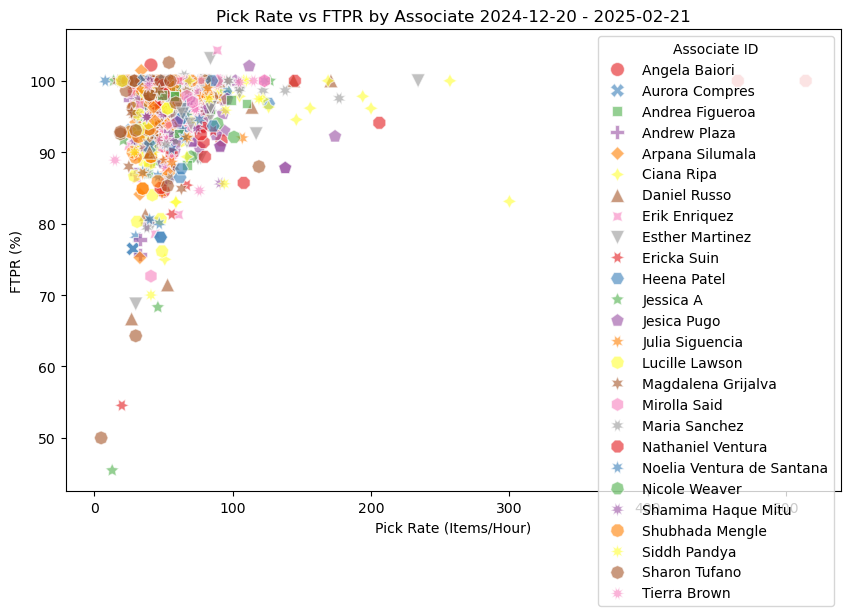

In [185]:
# Scatter plot with Pick Rate vs FTPR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Pick Rate', y='FTPR', hue='Associate Name', palette='Set1', style='Associate Name', s=100, alpha=0.6)
plt.title(f'Pick Rate vs FTPR by Associate {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Pick Rate (Items/Hour)')
plt.ylabel('FTPR (%)')
plt.legend(title='Associate ID')
plt.show()


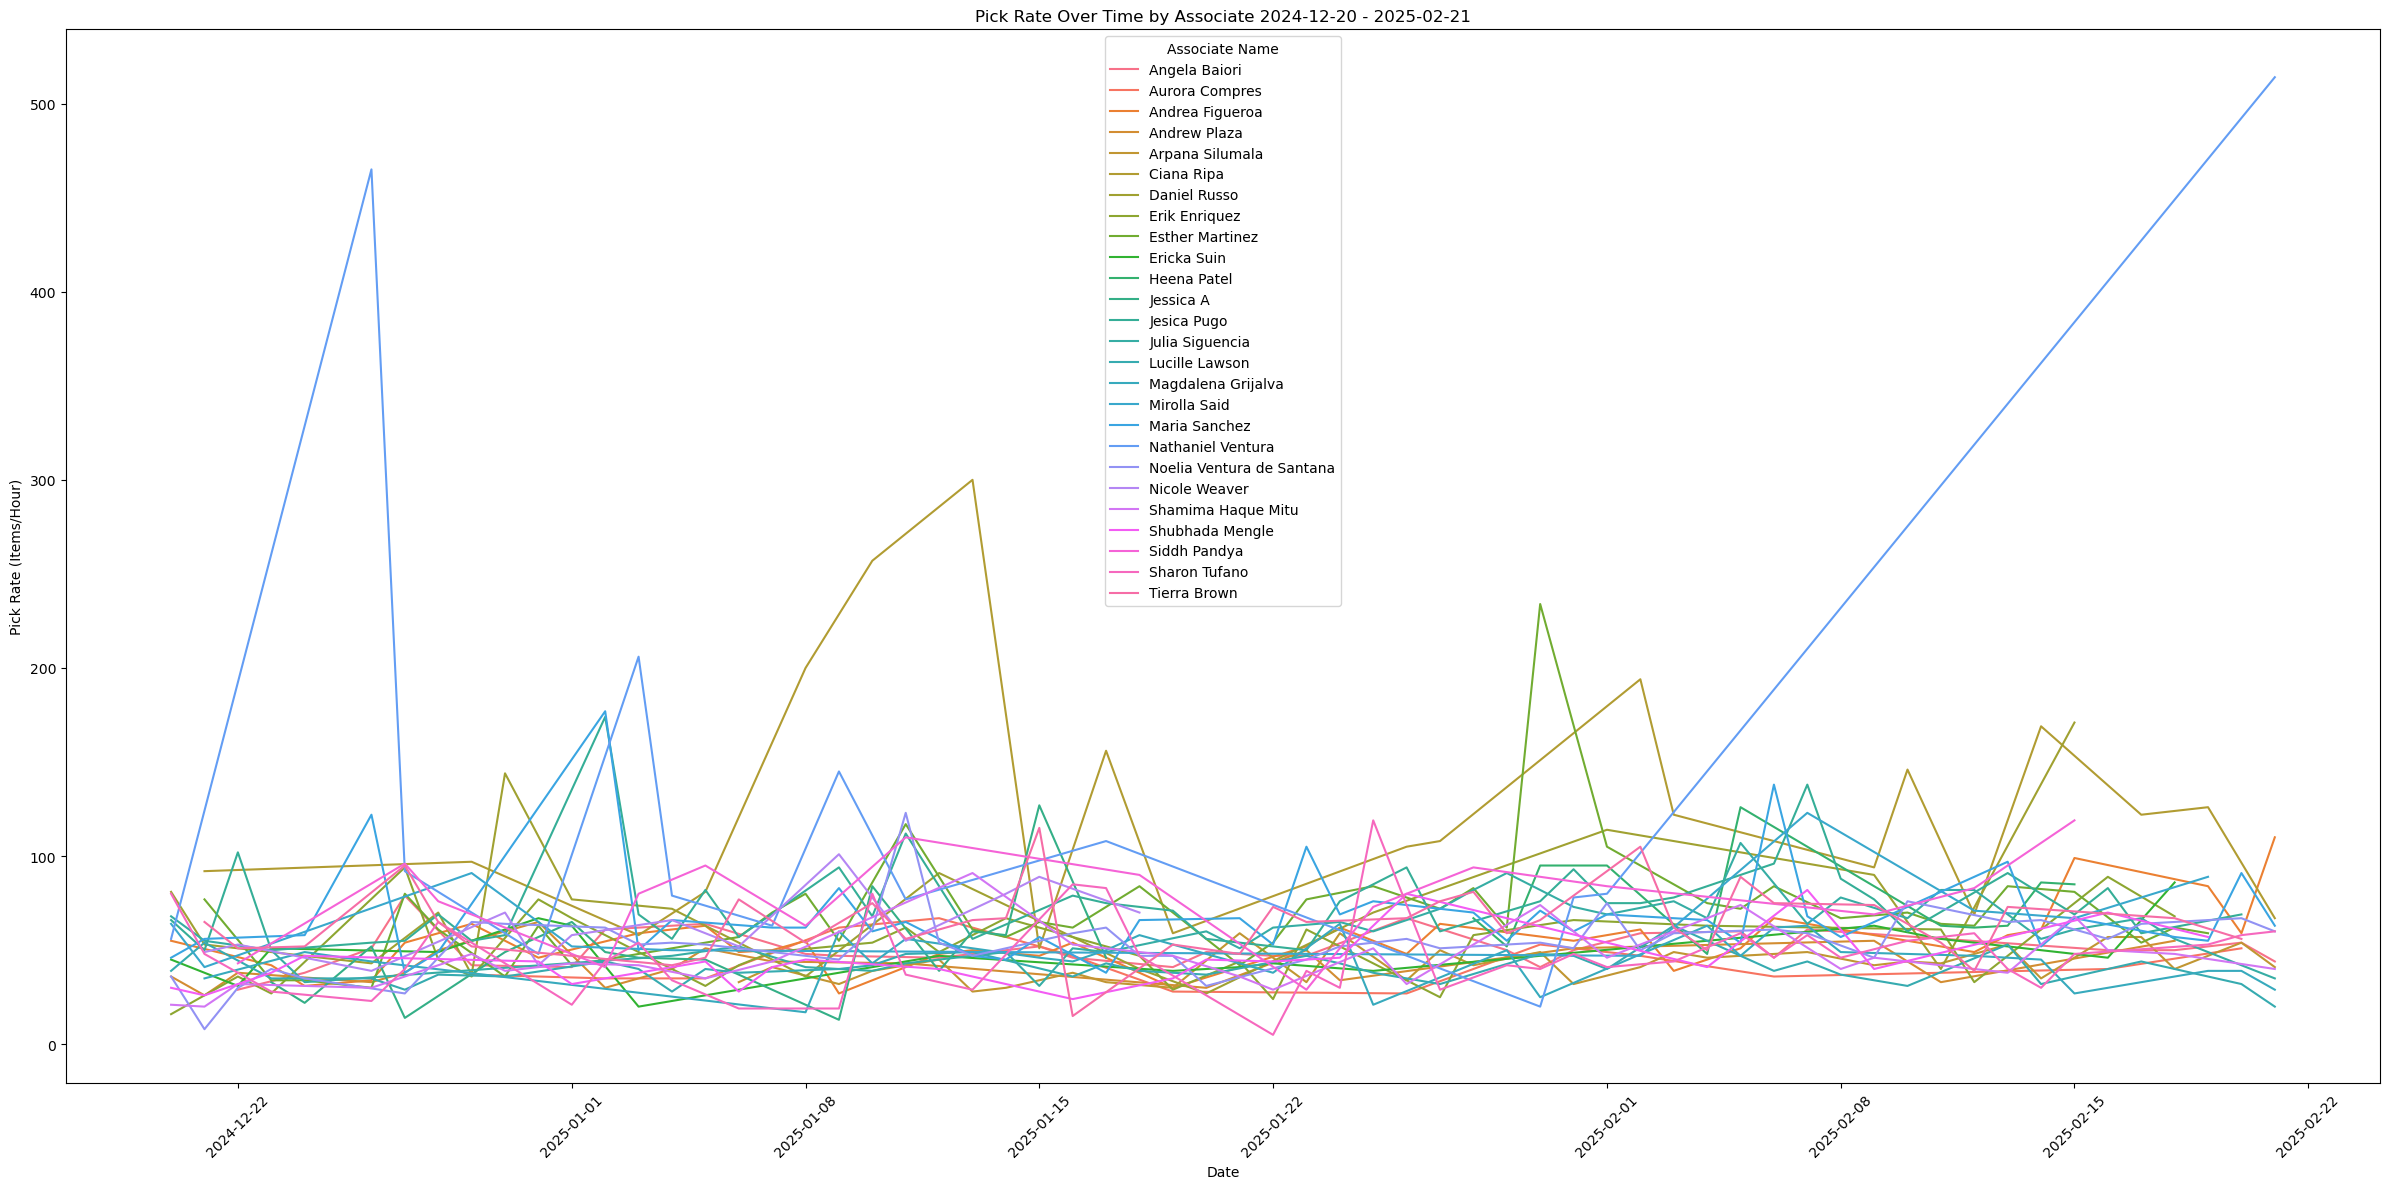

In [186]:
# Convert 'Day of Pick Date' to datetime format for time-based analysis
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')

# Line plot of Pick Rate over time for each Associate
plt.figure(figsize=(24, 12))
sns.lineplot(data=df, x='Day of Pick Date', y='Pick Rate', hue='Associate Name', markers=True)
plt.title(f'Pick Rate Over Time by Associate {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Date')
plt.ylabel('Pick Rate (Items/Hour)')
plt.xticks(rotation=45)
plt.legend(title='Associate Name')
plt.tight_layout()
plt.show()


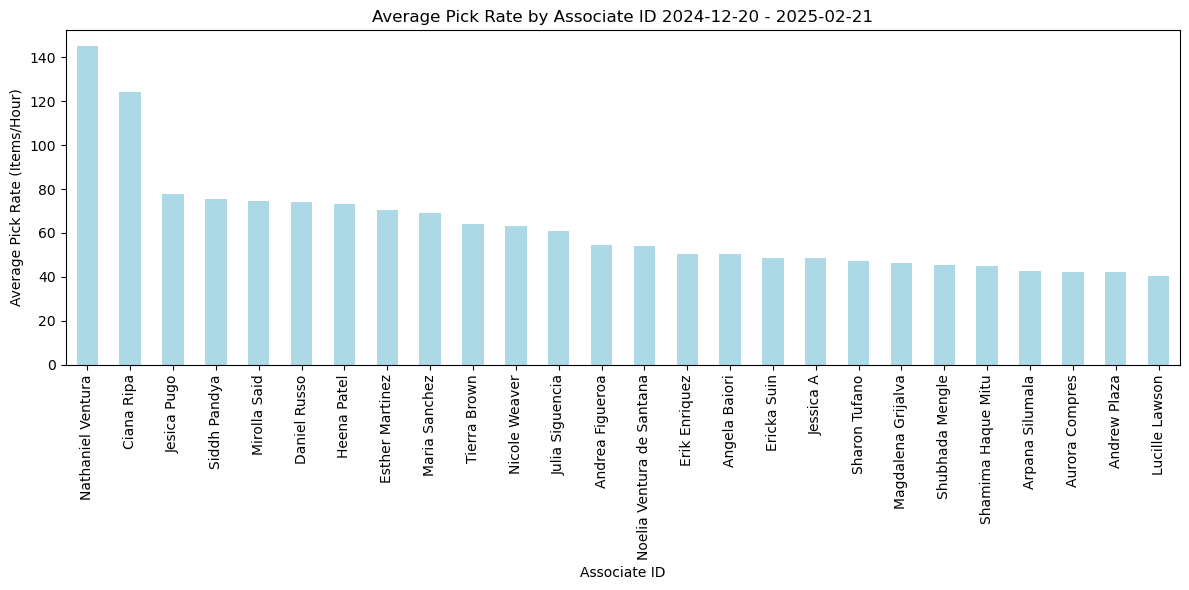

In [187]:
# Grouping by Associate ID and calculating average Pick Rate
avg_pick_rate = df.groupby('Associate Name')['Pick Rate'].mean().sort_values(ascending=False)

# Bar plot for average Pick Rate per Associate ID
plt.figure(figsize=(12, 6))
avg_pick_rate.plot(kind='bar', color='lightblue')
plt.title(f'Average Pick Rate by Associate ID {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Associate ID')
plt.ylabel('Average Pick Rate (Items/Hour)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


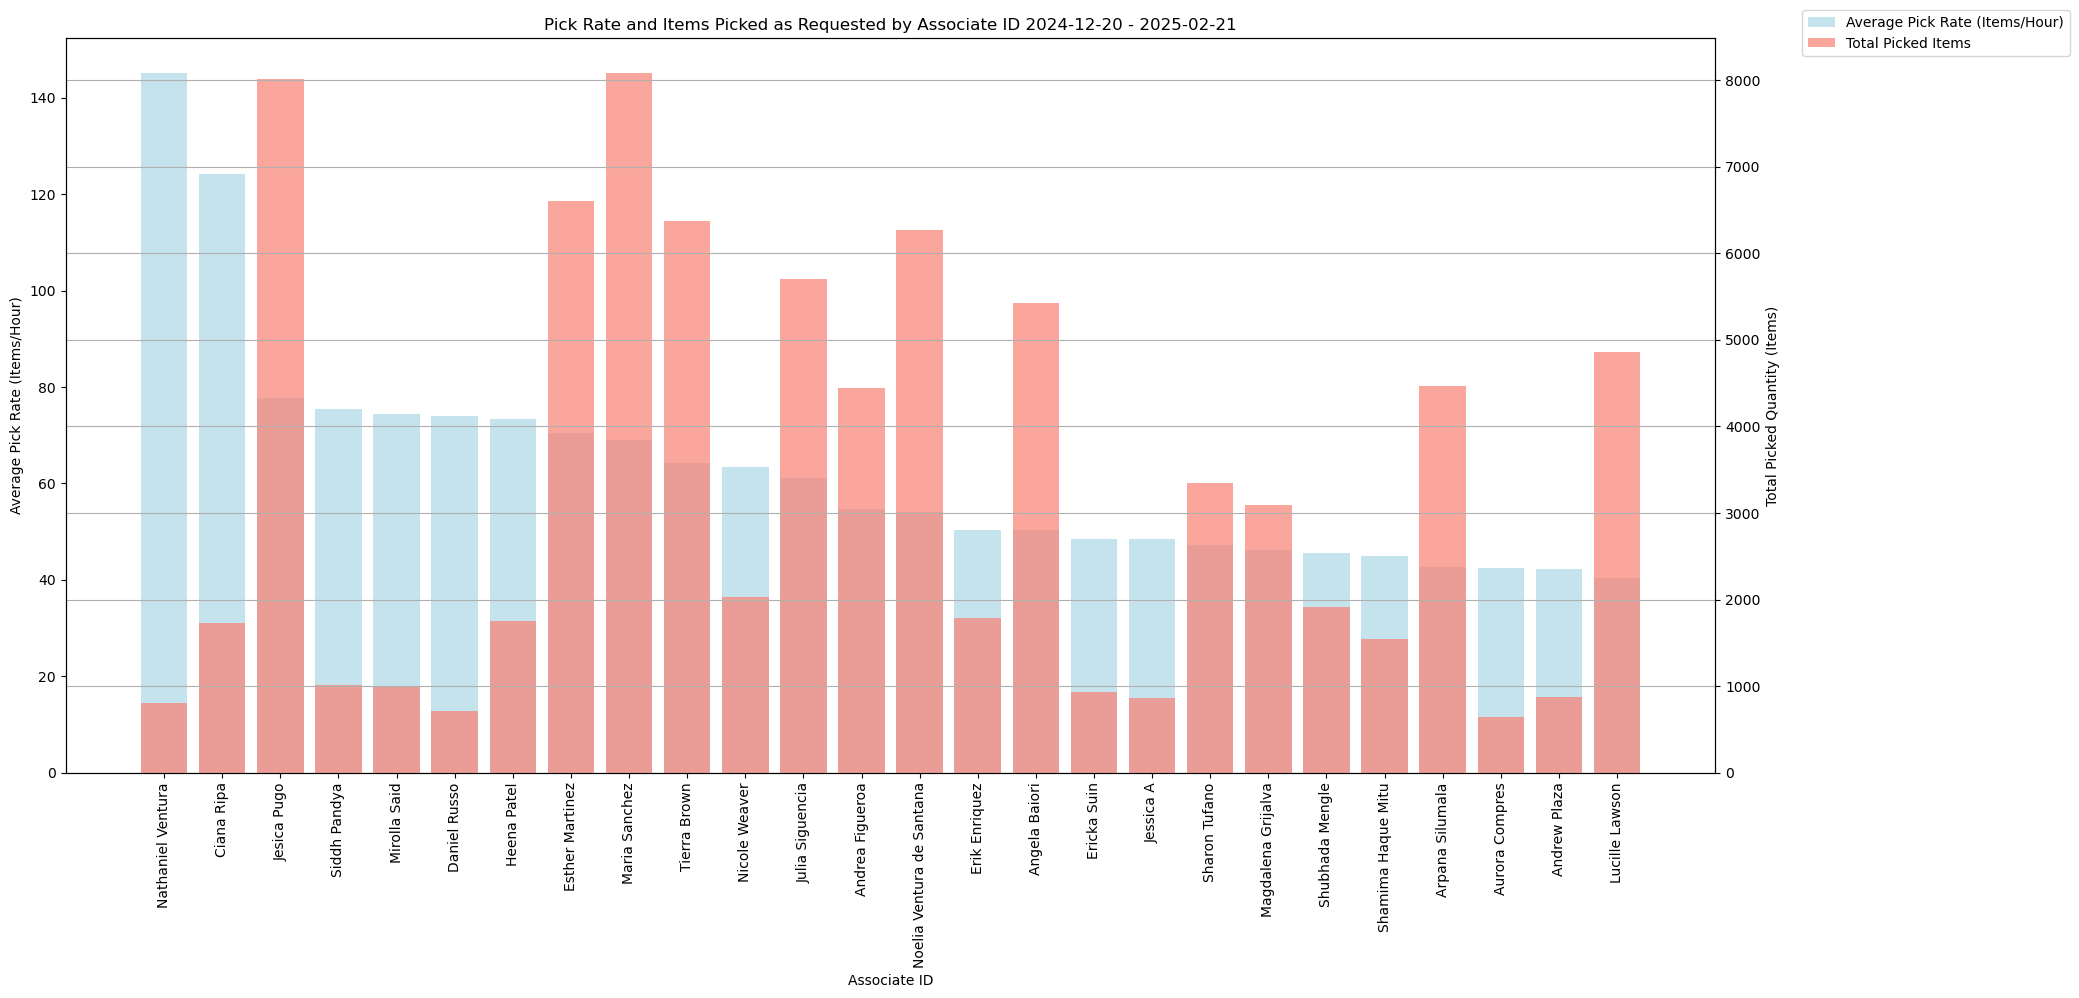

In [188]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_pick_rate = df_clean.groupby('Associate Name')['Pick Rate'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate Name')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_pick_rate.index, avg_pick_rate, color='lightblue', alpha=0.7, label='Average Pick Rate (Items/Hour)')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


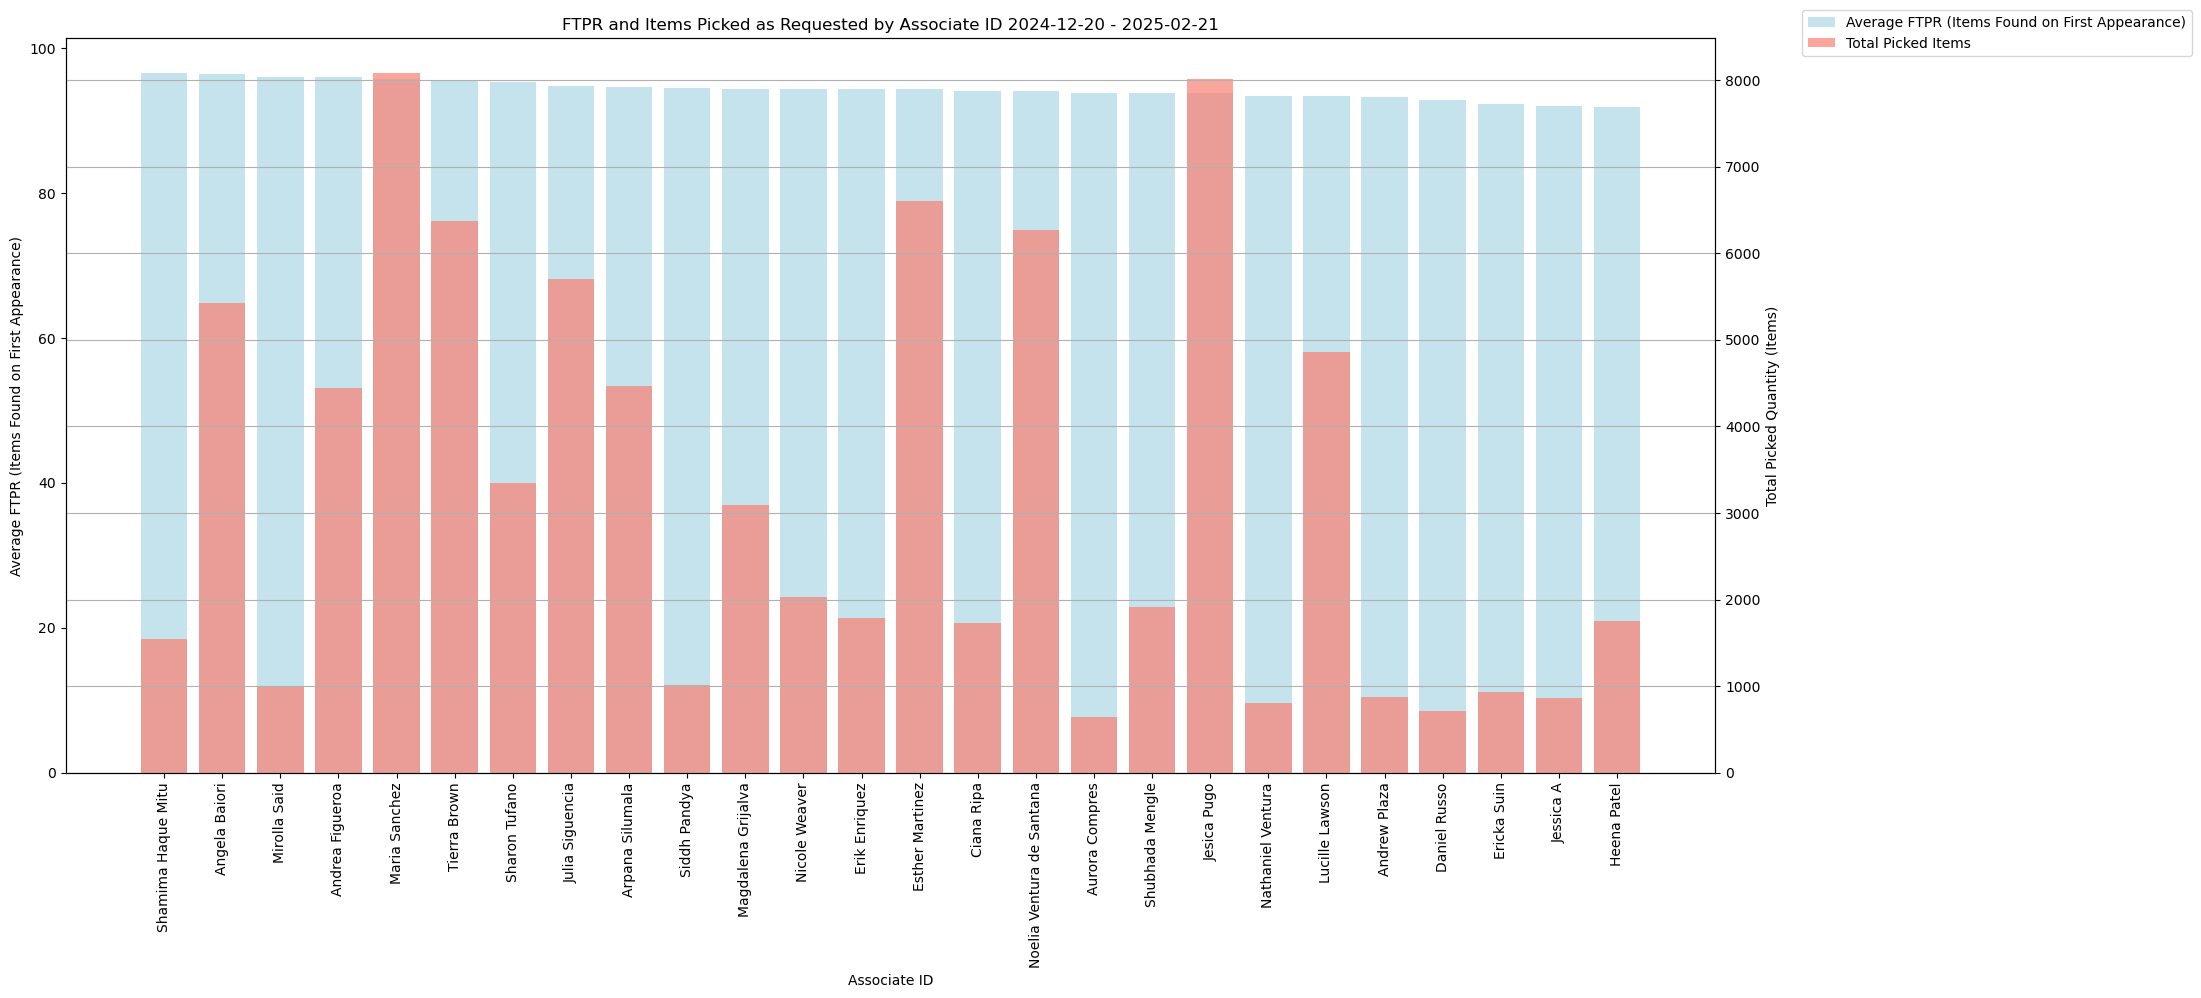

In [189]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['FTPR'] = pd.to_numeric(df['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'FTPR'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_ftpr = df_clean.groupby('Associate Name')['FTPR'].mean().astype(float).sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate Name')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_ftpr.index, avg_ftpr, color='lightblue', alpha=0.7, label='Average FTPR (Items Found on First Appearance)')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average FTPR (Items Found on First Appearance)')
ax1.set_title(f'FTPR and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()

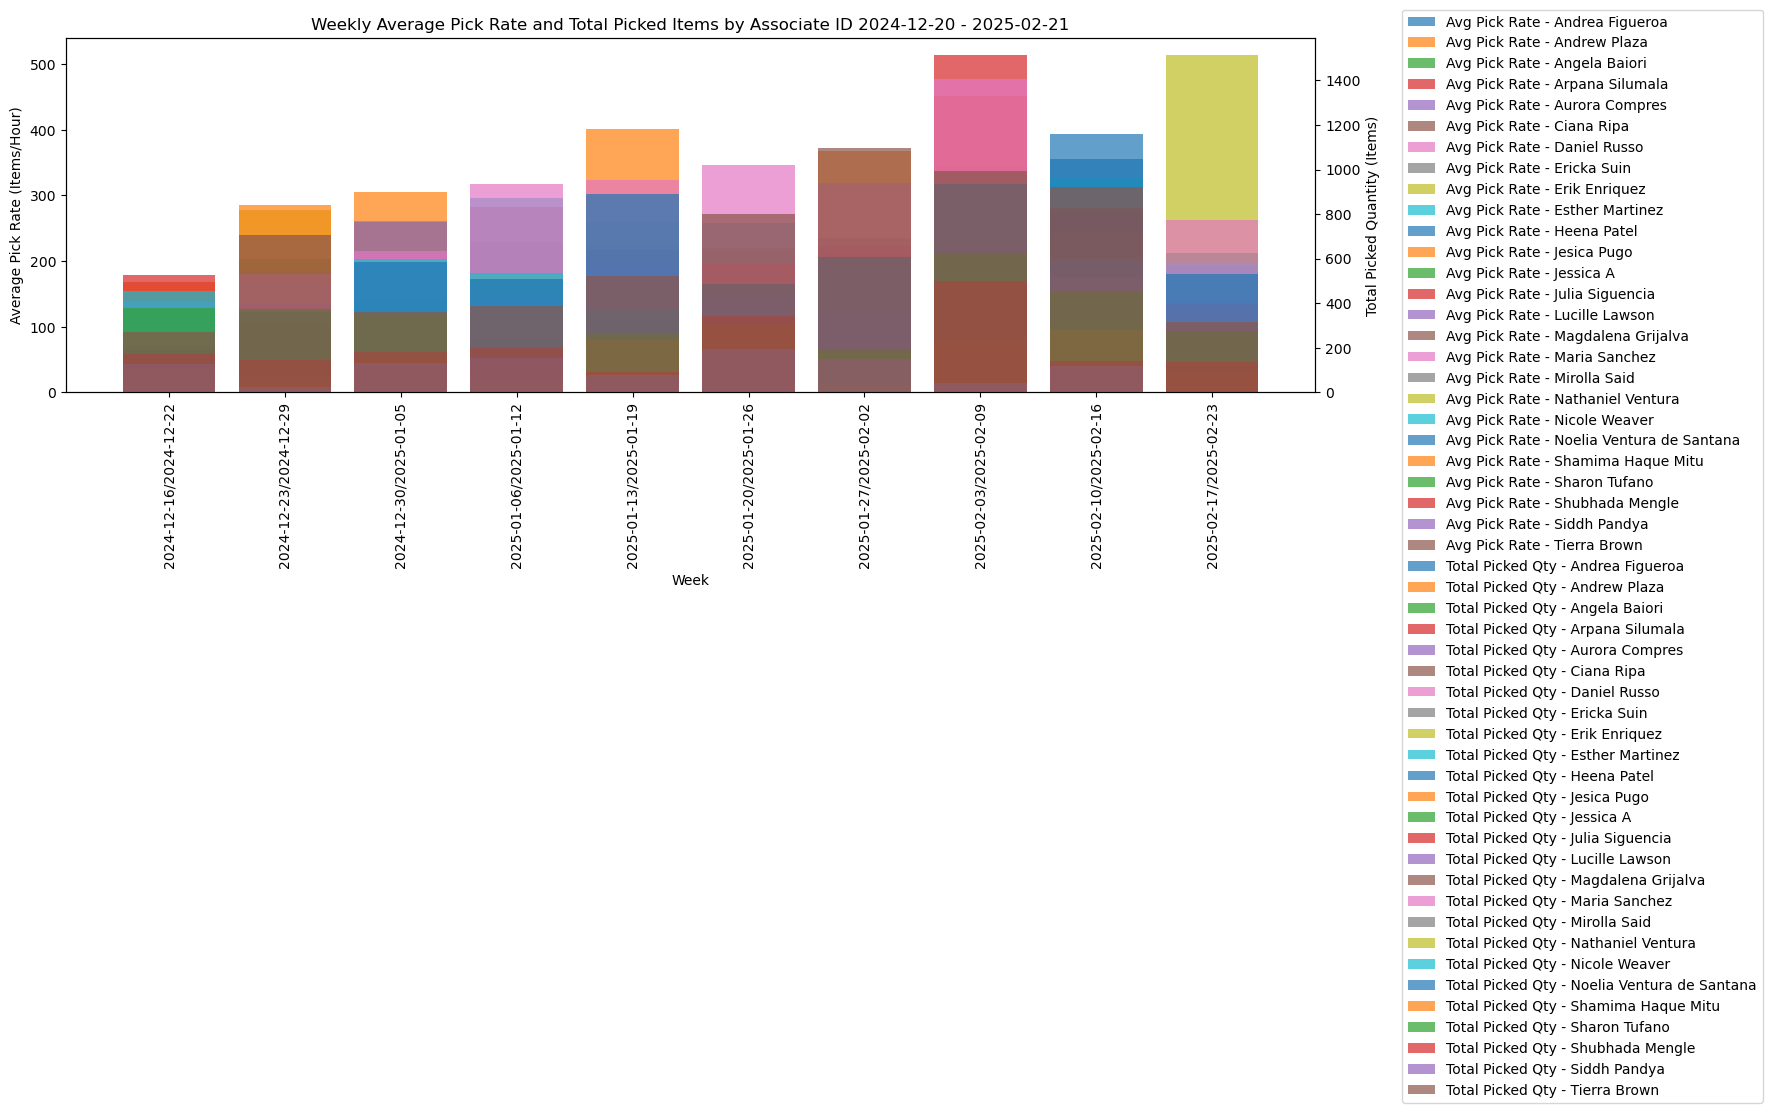

In [190]:
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and week (using 'Day of Pick Date' for weekly grouping)
# We're using pd.Grouper to group by week and Associate ID
df_clean['Week'] = df_clean['Day of Pick Date'].dt.to_period('W')

# Group by Week and Associate ID to calculate the sum of 'Picked As Req Qty' and average 'Pick Rate'
weekly_data = df_clean.groupby(['Week', 'Associate Name']).agg(
    avg_pick_rate=('Pick Rate', 'mean'),
    total_picked_qty=('Picked As Req Qty', 'sum')
).reset_index()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty by Week
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for average Pick Rate (items per hour) by Week
for label, data in weekly_data.groupby('Associate Name'):
    ax1.bar(data['Week'].astype(str), data['avg_pick_rate'], label=f'Avg Pick Rate - {label}', alpha=0.7)

ax1.set_xlabel('Week')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Weekly Average Pick Rate and Total Picked Items by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()

# Bar plot for total Picked As Req Qty by Week
for label, data in weekly_data.groupby('Associate Name'):
    ax2.bar(data['Week'].astype(str), data['total_picked_qty'], label=f'Total Picked Qty - {label}', alpha=0.7)

ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Week
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


In [191]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

'''# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in y_train
print("Class distribution in y_train:")
print(Counter(y_train))

# Check class distribution in y_test
print("\nClass distribution in y_test:")
print(Counter(y_test))

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Get probabilistic predictions (probabilities of the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilistic predictions here

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")'''

'# Assuming X and y are your features and target variable\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Check class distribution in y_train\nprint("Class distribution in y_train:")\nprint(Counter(y_train))\n\n# Check class distribution in y_test\nprint("\nClass distribution in y_test:")\nprint(Counter(y_test))\n\n# Oversample the minority class\nros = RandomOverSampler(random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Initialize and train the model\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_resampled, y_train_resampled)\n\n# Get probabilistic predictions (probabilities of the positive class)\ny_pred_proba = model.predict_proba(X_test)[:, 1]\n\n# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score\nthreshold = 0.5  # You can adjust this threshold as needed\ny_pred = (y_pred_proba >= threshold).astype(int)\n\n# Calculate metrics\n

In [192]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Assuming df is the DataFrame containing your data
threshold_pick_rate = 50
threshold_ftpr = 97.5
'''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) | 
                            (df['FTPR'] > threshold_ftpr)).astype(int)'''
df['Handled_Exceptions'] = (
    (df['Pick Rate'] < threshold_pick_rate) | 
    (df['FTPR'] > threshold_ftpr) | 
    (df['Exception Qty Req to Pick'] > 0) | 
    (df['Exception Nil Pick Qty'] > 0)
).astype(int)

print(df['Handled_Exceptions'].value_counts())

features = ['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']
target = 'Handled_Exceptions'
X = df[features]
y = df[target]

# Check if there are at least two classes in y
if len(np.unique(y)) < 2:
    print("Only one class present in the target variable. Cannot calculate ROC AUC score.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check if there are at least two classes in both y_train and y_test
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("Only one class present in either the training or test set. Cannot calculate ROC AUC score.")
    else:
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate ROC AUC score only if there are at least two classes in y_test
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")

# Perform grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Calculate cross-validation score
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-Validation Scores: {cross_val_scores}")

Handled_Exceptions
1    529
0    198
Name: count, dtype: int64
Accuracy: 0.9041095890410958
Precision: 0.9504950495049505
Recall: 0.9142857142857143
F1 Score: 0.9320388349514563
ROC AUC: 0.956678281068525
Best Parameters: {'max_depth': 5, 'n_estimators': 10}
Best Score: 0.8812113174182141
Cross-Validation Scores: [0.8974359  0.84482759 0.86206897 0.87931034 0.92241379]


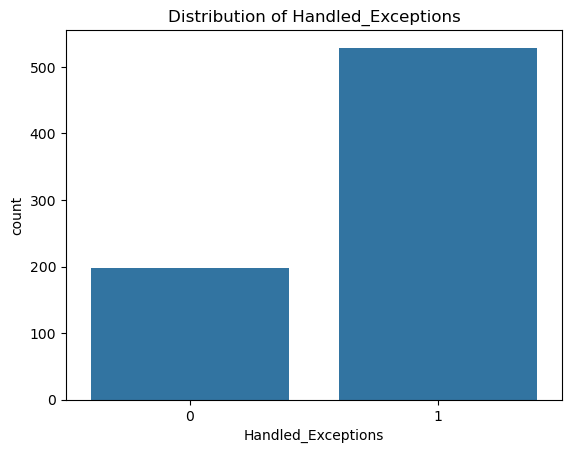

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Handled_Exceptions', data=df)
plt.title('Distribution of Handled_Exceptions')
plt.show()


In [194]:
start_time = time.time()
# Threshold ranges to test
threshold_pick_rate_values = np.linspace(5, 500, 8)  # Adjusted range, 100 
#print(threshold_pick_rate_values)
threshold_ftpr_values = np.linspace(70, 105, 12)       # Adjusted range, 300

# Variables to store the best thresholds and corresponding F1 score
best_thresholds = None
best_f1_score = -np.inf  # Initialize to a very low value
results = []  # Store results for each threshold combination

# Debugging: Check initial conditions
#print("Initial Threshold Values:")
#print(f"Pick Rate Thresholds: {threshold_pick_rate_values}")
#print(f"FTPR Thresholds: {threshold_ftpr_values}")

# Iterate through threshold combinations
for threshold_pick_rate in threshold_pick_rate_values:
    for threshold_ftpr in threshold_ftpr_values:
        # Create target variable based on thresholds
        df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) |
                                    (df['FTPR'] > threshold_ftpr)).astype(int)
        y = df['Handled_Exceptions']
        X = df[['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']]

        # Debugging: Check class distribution
        #print(f"Testing thresholds: Pick Rate={threshold_pick_rate}, FTPR={threshold_ftpr}")
        #print(f"Class distribution in 'y': {np.unique(y, return_counts=True)}")
        
        # Skip if there is only one class in the target variable
        if len(np.unique(y)) < 2:
            #print("Skipping: Only one class present in target variable")
            continue

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Skip if train/test split results in a single class
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            #print("Skipping: Only one class present in train/test sets")
            continue

        # Train a Random Forest model
        model = RandomForestClassifier(random_state=42) ############### n_jobs
        model.fit(X_train, y_train)

        # Make predictions and calculate F1 score
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        # Debugging: Print F1 score for the current thresholds
        #print(f"F1 Score for thresholds {threshold_pick_rate}, {threshold_ftpr}: {f1}")

        # Update the best thresholds if current F1 is higher
        if f1 > best_f1_score:
            best_f1_score = f1
            best_thresholds = (threshold_pick_rate, threshold_ftpr)
            #print(f"Updated Best Thresholds: {best_thresholds} with F1={best_f1_score}")

        # Store the results for analysis
        results.append({
            'Pick Rate Threshold': threshold_pick_rate,
            'FTPR Threshold': threshold_ftpr,
            'F1 Score': f1
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best thresholds and their corresponding F1 score
if best_thresholds is None:
    print("No valid threshold combination was found. Adjust thresholds or data distribution.")
else:
    print(f"Best Thresholds: Pick Rate={best_thresholds[0]}, FTPR={best_thresholds[1]}")
    print(f"Best F1 Score: {best_f1_score}")

# Optional: Summarize all tested threshold combinations
if not results_df.empty:
    print("Summary of Top Threshold Combinations:")
    print(results_df.sort_values(by='F1 Score', ascending=False).head())
else:
    print("No valid results were generated.")
end_time = time.time()
print(f'time to run model for {threshold_pick_rate_values.size * threshold_ftpr_values.size} combinations: {end_time - start_time}')

Best Thresholds: Pick Rate=5.0, FTPR=73.18181818181819
Best F1 Score: 1.0
Summary of Top Threshold Combinations:
    Pick Rate Threshold  FTPR Threshold  F1 Score
10             5.000000      101.818182       1.0
9              5.000000       98.636364       1.0
19           146.428571      101.818182       1.0
18           146.428571       98.636364       1.0
17            75.714286      105.000000       1.0
time to run model for 96 combinations: 0.9627163410186768


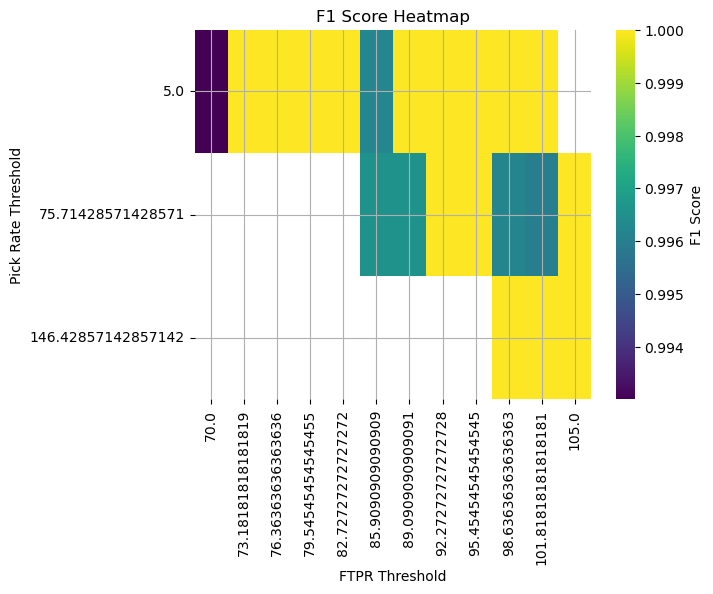

In [195]:
# Ensure results_df is not empty
if not results_df.empty:
    # Rename columns for compatibility with pivot (optional, just for consistency)
    results_df.rename(columns={
        'Pick Rate Threshold': 'pick_rate',
        'FTPR Threshold': 'ftpr',
        'F1 Score': 'f1'
    }, inplace=True)

    # Create pivot table
    pivot_table = results_df.pivot(index='pick_rate', columns='ftpr', values='f1')

    # Generate heatmap
    sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'F1 Score'})
    plt.title("F1 Score Heatmap")
    plt.xlabel("FTPR Threshold")
    plt.ylabel("Pick Rate Threshold")
    plt.grid()
    plt.show()
else:
    print("No data to plot. Ensure valid results are generated before creating a heatmap.")

In [196]:
print(df['Pick Rate'].describe())
print(df['FTPR'].describe())
print(df['Handled_Exceptions'].value_counts())
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")


count    727.000000
mean      60.185695
std       36.549147
min        5.000000
25%       42.000000
50%       54.000000
75%       67.000000
max      514.000000
Name: Pick Rate, dtype: float64
count    727.000000
mean      94.523549
std        6.069243
min       45.450000
25%       92.890000
50%       95.830000
75%       98.190000
max      104.260000
Name: FTPR, dtype: float64
Handled_Exceptions
1    726
0      1
Name: count, dtype: int64
FTPR: 0.008029907688014579
Pick Rate: 0.7319604930677924
Pick Hours: 0.1518302106133094
Qty Req to Pick: 0.0461921595581643
Picked As Req Qty: 0.061987229072719356


<h2>Composite Scoring Starts Here</h2>
<h4>Composite Scoring Modifiers for standardized evaluation throughtout notebook</h4>
<ul>pickrate_modifier</ul>
<ul>ftpr_modifier</ul>
<ul>picked_as_req_modifier</ul>

In [197]:
pickrate_modifier = 0.3
ftpr_modifier = 0.4
picked_as_req_modifier = 0.3
# Define a composite score for each row (or use one metric like 'Pick Rate' directly)
df['Composite_Score'] = (
    picked_as_req_modifier * df['Picked As Req Qty'] +  # Weight for Items Picked
    pickrate_modifier * df['Pick Rate'] +       # Weight for Pick Rate
    ftpr_modifier * df['FTPR']              # Weight for FTPR
)

# Find the best day for each associate
best_days = df.loc[df.groupby('Associate Name')['Composite_Score'].idxmax()]

# Sort associates by their best day's composite score unfiltered
top_associates = best_days.sort_values(by=['Composite_Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day
print(top_associates[['Associate Name', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']].head(10))

# Filter out associates with fewer than a certain number of items picked
best_days_filtered = best_days[best_days['Picked As Req Qty'] > 50]

# Sort associates by their best day's composite score filtered
top_associates_filtered = best_days_filtered.sort_values(by=['Composite_Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day after pick qty filtered
print(f'\nAfter filtering out Associates with < 50 Picked As Req Qty')
print(top_associates_filtered[['Associate Name', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']].head(10))

         Associate Name Day of Pick Date  Picked As Req Qty  Pick Rate    FTPR  Composite_Score
1333       Tierra Brown       2025-02-02                469      105.0   99.79          212.116
1246  Nathaniel Ventura       2025-02-21                  1      514.0  100.00          194.500
131         Jesica Pugo       2025-02-08                407       88.0   92.43          185.472
780          Ciana Ripa       2025-01-13                192      300.0   83.12          180.848
211         Heena Patel       2025-02-01                324       95.0   97.87          164.848
706       Angela Baiori       2025-01-02                339       61.0   97.13          158.852
1016      Maria Sanchez       2025-01-18                336       66.0   94.65          158.460
1074      Nicole Weaver       2025-01-09                304      101.0   92.12          158.348
873     Esther Martinez       2025-01-11                287      117.0   92.58          158.232
971     Julia Siguencia       2024-12-20

In [198]:
#df.loc[df["Associate ID"] == 'n0v0359']

<h2>Top Composite Score of the Week</h2>

In [199]:
#Top Associate Per Week
# Aggregate metrics for each associate per week
weekly_performance = df.groupby(['Custom Week Start', 'Associate Name'], as_index=False).agg({
    'Picked As Req Qty': 'sum',  # Total items picked in the week
    'Pick Rate': 'mean',       # Average pick rate for the week
    'FTPR': 'mean',            # Average FTPR for the week
    'Pick Hours': 'sum'        # Total hours worked in the week (optional)
})

# Add a composite score to rank performance in each week
weekly_performance['Composite_Score'] = (
    picked_as_req_modifier * weekly_performance['Picked As Req Qty'] +
    pickrate_modifier * weekly_performance['Pick Rate'] +
    ftpr_modifier * weekly_performance['FTPR']
)

# Sort associates within each week by Composite Score
weekly_performance = weekly_performance.sort_values(by=['Custom Week Start', 'Composite_Score'], ascending=[True, False])

# Add a rank column within each week
weekly_performance['Rank'] = weekly_performance.groupby('Custom Week Start')['Composite_Score'].rank(method='dense', ascending=False)

# Get the top associate for each week
top_associates_per_week = weekly_performance[weekly_performance['Rank'] == 1]

# Display the results
print(top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']])


    Custom Week Start   Associate Name  Picked As Req Qty  Pick Rate       FTPR  Composite_Score
6          2024-12-14  Julia Siguencia                336  68.000000  92.020000       158.008000
23         2024-12-21      Jesica Pugo                771  62.200000  92.556000       286.982400
47         2024-12-28      Jesica Pugo                921  85.000000  93.254000       339.101600
74         2025-01-04    Maria Sanchez                929  66.600000  95.660000       336.944000
99         2025-01-11    Maria Sanchez                883  50.400000  93.936000       317.594400
122        2025-01-18    Maria Sanchez               1048  72.000000  96.088000       374.435200
145        2025-01-25    Maria Sanchez                962  66.400000  97.222000       347.408800
163        2025-02-01  Julia Siguencia               1466  73.428571  95.697143       500.107429
195        2025-02-08     Tierra Brown               1148  62.600000  96.326000       401.710400
211        2025-02-15    Maria

<h2>WTD Composite Score Rankings</h2>

In [200]:
# Calculate Composite Score (can modify the weights here as needed)
df['Composite_Score'] = (df['Pick Rate'] * pickrate_modifier) + (df['FTPR'] * ftpr_modifier) + (df['Picked As Req Qty'] * picked_as_req_modifier)

# Filter rows where Picked As Req Qty is less than num
num = 1
df_filtered = df[df['Picked As Req Qty'] >= num]

# Specify the week for analysis
week_of_interest = '2025-01-18 to 2025-01-24' #manual range
week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
df_week = df_filtered[df_filtered['Week'] == week_of_interest]

# Get the best day per associate within the week based on Composite_Score
best_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite_Score'].idxmax()]

# Rank the associates based on Composite_Score within the week
best_day_of_week['Rank'] = best_day_of_week['Composite_Score'].rank(ascending=False, method='min')

# Sort by rank (ascending gives top performer first)
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display the results
print('WTD Composite Scores')
print(f'Week: {week_of_interest}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']])
best_day_of_week_printdf = best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']]
best_day_of_week_printdf.head(15)

WTD Composite Scores
Week: 2025-02-15 to 2025-02-21


Associate Name Day of Pick Date  Pick Rate    FTPR  Picked As Req Qty  Composite_Score  Rank
1246          Nathaniel Ventura       2025-02-21      514.0  100.00                  1          194.500   1.0
259                  Ciana Ripa       2025-02-17      122.0   97.40                226          143.360   2.0
1200            Esther Martinez       2025-02-19       59.0   96.38                271          137.552   3.0
1179            Andrea Figueroa       2025-02-19       84.0   96.08                245          137.132   4.0
1242              Maria Sanchez       2025-02-21       63.0   96.21                254          133.584   5.0
1221               Tierra Brown       2025-02-18       67.0   98.33                236          130.232   6.0
275   Noelia Ventura de Santana       2025-02-17       64.0   93.06                238          127.824   7.0
1226              Angela Baiori       2025-02-21       44.0   96.84                245          125.436   8.0
246                 Jesica Pugo       2025-02-16       83.0   96.17                178          116.768   9.0
350                Mirolla Said       2025-02-15       67.0   97.86                183          114.144  10.0
337             Julia Siguencia       2025-02-15       61.0   98.15                161          105.860  11.0
254             Shubhada Mengle       2025-02-16       70.0  100.00                142          103.600  12.0
1198              Erik Enriquez       2025-02-18       68.0   93.29                149          102.416  13.0
321                Daniel Russo       2025-02-15      171.0  100.00                 36          102.100  14.0
1252              Sharon Tufano       2025-02-21       60.0   97.92                141           99.468  15.0

<h2>Composite Score Rankings LW</h2>

In [201]:
# Calculate Composite Score
df['Composite_Score'] = (
    (df['Pick Rate'] * pickrate_modifier) + 
    (df['FTPR'] * ftpr_modifier) + 
    (df['Picked As Req Qty'] * picked_as_req_modifier)
)

# Set today’s date
today = datetime.now()

# Find the last full week's end date (before today)
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

# Filter data for the last full week
df_week = df[(df['Custom Week Start'] == last_full_week_start) & (df['Custom Week End'] == last_full_week_end)]

# Get the best day per associate within the last full week based on Composite_Score
best_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite_Score'].idxmax()].copy()

# Rank associates by Composite_Score (descending order)
best_day_of_week['Rank'] = best_day_of_week['Composite_Score'].rank(ascending=False, method='min')

# Sort by rank
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15))
best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15)

LW Composite Scores
Week: 2025-02-15 - 2025-02-21


Associate Name Day of Pick Date  Pick Rate    FTPR  Picked As Req Qty  Composite_Score  Rank
1246          Nathaniel Ventura       2025-02-21      514.0  100.00                  1          194.500   1.0
259                  Ciana Ripa       2025-02-17      122.0   97.40                226          143.360   2.0
1200            Esther Martinez       2025-02-19       59.0   96.38                271          137.552   3.0
1179            Andrea Figueroa       2025-02-19       84.0   96.08                245          137.132   4.0
1242              Maria Sanchez       2025-02-21       63.0   96.21                254          133.584   5.0
1221               Tierra Brown       2025-02-18       67.0   98.33                236          130.232   6.0
275   Noelia Ventura de Santana       2025-02-17       64.0   93.06                238          127.824   7.0
1226              Angela Baiori       2025-02-21       44.0   96.84                245          125.436   8.0
246                 Jesica Pugo       2025-02-16       83.0   96.17                178          116.768   9.0
350                Mirolla Said       2025-02-15       67.0   97.86                183          114.144  10.0
337             Julia Siguencia       2025-02-15       61.0   98.15                161          105.860  11.0
254             Shubhada Mengle       2025-02-16       70.0  100.00                142          103.600  12.0
1198              Erik Enriquez       2025-02-18       68.0   93.29                149          102.416  13.0
321                Daniel Russo       2025-02-15      171.0  100.00                 36          102.100  14.0
1252              Sharon Tufano       2025-02-21       60.0   97.92                141           99.468  15.0

<h2>Lowest Performing Associates by Day LW (Composite Score)</h2>

In [202]:
# Get the best day per associate within the last full week based on Composite_Score
worst_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite_Score'].idxmin()].copy()

# Rank associates by Composite_Score (descending order)
worst_day_of_week['Rank'] = worst_day_of_week['Composite_Score'].rank(ascending=False, method='min')

# Sort by rank
worst_day_of_week_sorted = worst_day_of_week.sort_values(by='Rank', ascending=False)

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15))
worst_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15)

LW Composite Scores
Week: 2025-02-15 - 2025-02-21


Associate Name Day of Pick Date  Pick Rate    FTPR  Picked As Req Qty  Composite_Score  Rank
1240  Magdalena Grijalva       2025-02-21       29.0   95.24                 20           52.796  24.0
1250  Shamima Haque Mitu       2025-02-21       40.0  100.00                  4           53.200  23.0
1238      Lucille Lawson       2025-02-21       20.0  100.00                 25           53.500  22.0
1217       Sharon Tufano       2025-02-19       53.0   85.29                 29           58.716  21.0
1261      Aurora Compres       2025-02-20       51.0  100.00                 35           65.800  20.0
1236     Julia Siguencia       2025-02-21       35.0   87.06                 77           68.424  19.0
1232          Ciana Ripa       2025-02-21       67.0   89.36                 42           68.444  18.0
1181        Andrew Plaza       2025-02-18       55.0   93.06                 69           74.424  17.0
1196         Ericka Suin       2025-02-18       86.0   93.02                 41           75.308  16.0
330          Heena Patel       2025-02-15       85.0  100.00                 42           78.100  15.0
1283        Tierra Brown       2025-02-20       56.0   97.50                 78           79.200  14.0
1259     Arpana Silumala       2025-02-20       54.0   87.04                 94           79.216  13.0
1210        Mirolla Said       2025-02-19       89.0  100.00                 47           80.800  12.0
242        Erik Enriquez       2025-02-16       89.0  104.26                 49           83.104  11.0
1275       Maria Sanchez       2025-02-20       91.0  100.00                 63           86.200  10.0

<h2>Lowest FTPR Associates for LW</h2>

In [203]:
lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'].idxmin()].copy()
#lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'] <= 90.0].copy()

lowest_ftpr = lowest_ftpr.loc[lowest_ftpr['FTPR'] <= 90.0]
# Rank associates by Composite_Score (descending order)
lowest_ftpr['Rank'] = lowest_ftpr['Composite_Score'].rank(ascending=False, method='min')
lowest_ftpr = lowest_ftpr.sort_values(by='FTPR', ascending=True)
# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15))
lowest_ftpr[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']]


LW Composite Scores
Week: 2025-02-15 - 2025-02-21


Associate Name Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Composite_Score  Rank
1217    Sharon Tufano       2025-02-19       53.0  85.29                 29           58.716   5.0
1207    Maria Sanchez       2025-02-19       55.0  86.35                253          126.940   1.0
1259  Arpana Silumala       2025-02-20       54.0  87.04                 94           79.216   2.0
1236  Julia Siguencia       2025-02-21       35.0  87.06                 77           68.424   4.0
1232       Ciana Ripa       2025-02-21       67.0  89.36                 42           68.444   3.0

<h2>Model to Predict FTPR and Pick Rate</h2>

In [204]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

start_time = time.time()
# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Use the trained models to predict performance for each associate in df
df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))

end_time = time.time()
print(f'Total time: {end_time - start_time}')
# Print predicted metrics for each associate
for associate_id in df['Associate ID'].unique():
    associate_df = df[df['Associate ID'] == associate_id]
    print(f"Associate ID: {associate_id}")
    print("Predicted Metrics:")
    print(associate_df[['FTPR', 'Pick Rate', 'Predicted FTPR', 'Predicted Pick Rate']])
    print()
df.head(10)

Best Parameters for FTPR: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score for FTPR: 17.531126915608667
FTPR Prediction Metrics:
MSE: 46.453859284777685
R2 Score: 0.2613308275131545
Best Parameters for Pick Rate: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Score for Pick Rate: 736.9518254644211
Pick Rate Prediction Metrics:
MSE: 144.67480612130743
R2 Score: 0.759026148464358
Total time: 7.318850040435791
Associate ID: a0b0ad9
Predicted Metrics:
        FTPR  Pick Rate  Predicted FTPR  Predicted Pick Rate
46     97.01       60.0       96.331990            60.512625
1309   97.03       59.0       95.968203            59.628481
708    92.92       42.0       95.726424            43.222571
709   100.00       79.0       99.449360            81.031755
710    92.66       51.0       94.471357            51.384718
711    95.83       38.0       97.078727            37.755625
712    98.53       29.0    

Associate ID Associate Name Day of Pick Date    FTPR  Pick Rate  Pick Hours  Qty Req to Pick  Picked As Req Qty  Substitution Qty  Nil Pick Qty  ...  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Custom Week Start Custom Week End                      Week Handled_Exceptions  Composite_Score  Predicted FTPR  Predicted Pick Rate
46        a0b0ad9  Angela Baiori       2025-02-05   97.01       60.0        3.86            233.0                227                 4             3  ...                            0                           0                       0         2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                  1          124.904       96.331990            60.512625
1309      a0b0ad9  Angela Baiori       2025-02-02   97.03       59.0        4.36            268.0                254                 2            10  ...                            0                           0                       0         2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                  1          132.712       95.968203            59.628481
708       a0b0ad9  Angela Baiori       2024-12-29   92.92       42.0        4.88            214.0                199                 6             4  ...                            0                           0                       0         2024-12-28      2025-01-03  2024-12-28 to 2025-01-03                  1          109.468       95.726424            43.222571
709       a0b0ad9  Angela Baiori       2024-12-27  100.00       79.0        0.60             47.0                 47                 0             0  ...                            0                           0                       0         2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                  1           77.800       99.449360            81.031755
710       a0b0ad9  Angela Baiori       2024-12-26   92.66       51.0        4.18            223.0                212                 3             5  ...                            0                           0                       2         2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                  1          115.964       94.471357            51.384718
711       a0b0ad9  Angela Baiori       2024-12-24   95.83       38.0        3.76            146.0                141                 1             1  ...                            0                           0                       0         2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                  1           92.032       97.078727            37.755625
712       a0b0ad9  Angela Baiori       2024-12-22   98.53       29.0        4.67            138.0                134                 3             2  ...                            0                           0                       0         2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                  1           88.312       96.355444            33.850559
702       a0b0ad9  Angela Baiori       2025-01-09   97.25       47.0        3.80            179.0                177                 2             2  ...                            0                           0                       8         2025-01-04      2025-01-10  2025-01-04 to 2025-01-10                  1          106.100       95.484144            47.351762
703       a0b0ad9  Angela Baiori       2025-01-08   97.50       48.0        1.64             85.0                 78                 0             5  ...                            0                           0                       0         2025-01-04      2025-01-10  2025-01-04 to 2025-01-10                  1           76.800       96.054049            49.124461
705       a0b0ad9  Angela Baiori       2025-01-05   98.89       64.0        4.28            273.0                269                 4             0  ...                            0                           0                       0         2025-01-04      2025-01-10  2025-01-04 to 2025-01-10                  1 

<h2>Predicts Team Average values based on all Historical Data</h2>

In [205]:
# Adds Picked as Req Qty to predictions

start_time = time.time()
# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
        'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Picked As Req Qty prediction
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

# Print best parameters and corresponding score for Picked As Req Qty prediction
print("Best Parameters for Picked As Req Qty:", grid_search_picked_as_req_qty.best_params_)
print("Best Score for Picked As Req Qty:", -grid_search_picked_as_req_qty.best_score_)

# Train a model with the best parameters and evaluate on test data for Picked As Req Qty prediction
best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

# Print evaluation metrics for Picked As Req Qty prediction
print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to predict performance for each associate
predicted_df = pd.DataFrame({
    'FTPR': y_pred_ftpr,
    'Pick Rate': y_pred_pick_rate,
    'Picked As Req Qty': y_pred_picked_as_req_qty
})

print(predicted_df.head())

# Calculate overall metrics
overall_mse = (ftpr_mse + pick_rate_mse + picked_as_req_qty_mse) / 3
overall_r2 = (ftpr_r2 + pick_rate_r2 + picked_as_req_qty_r2) / 3

end_time = time.time()
print(f"Overall MSE: {overall_mse}")
print(f"Overall R2 Score: {overall_r2}")
print(f'Total time: {end_time - start_time}')
######before n_jobs=-1, total time = 85.37645697593689 M4 Max

Best Parameters for FTPR: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Score for FTPR: 18.813205674360454
FTPR Prediction Metrics:
MSE: 48.140159539070474
R2 Score: 0.23451673644341675
Best Parameters for Pick Rate: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score for Pick Rate: 744.1258895433369
Pick Rate Prediction Metrics:
MSE: 119.03217577910542
R2 Score: 0.8017371329317157
Best Parameters for Picked As Req Qty: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Best Score for Picked As Req Qty: 136.76189374125775
Picked As Req Qty Prediction Metrics:
MSE: 50.23869955667945
R2 Score: 0.9919518578548241
        FTPR  Pick Rate  Picked As Req Qty
0  95.327803  67.211262           7.390476
1  94.681855  52.999074         201.558333
2  98.956903  80.167903         119.431667
3  95.225575  48.788655           9.618571
4  99.348269  50.348635          30.616667


In [206]:
df.head()

Associate ID Associate Name Day of Pick Date    FTPR  Pick Rate  Pick Hours  Qty Req to Pick  Picked As Req Qty  Substitution Qty  Nil Pick Qty  ...  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Custom Week Start Custom Week End                      Week Handled_Exceptions  Composite_Score  Predicted FTPR  Predicted Pick Rate
46        a0b0ad9  Angela Baiori       2025-02-05   97.01       60.0        3.86            233.0                227                 4             3  ...                            0                           0                       0         2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                  1          124.904       96.331990            60.512625
1309      a0b0ad9  Angela Baiori       2025-02-02   97.03       59.0        4.36            268.0                254                 2            10  ...                            0                           0                       0         2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                  1          132.712       95.968203            59.628481
708       a0b0ad9  Angela Baiori       2024-12-29   92.92       42.0        4.88            214.0                199                 6             4  ...                            0                           0                       0         2024-12-28      2025-01-03  2024-12-28 to 2025-01-03                  1          109.468       95.726424            43.222571
709       a0b0ad9  Angela Baiori       2024-12-27  100.00       79.0        0.60             47.0                 47                 0             0  ...                            0                           0                       0         2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                  1           77.800       99.449360            81.031755
710       a0b0ad9  Angela Baiori       2024-12-26   92.66       51.0        4.18            223.0                212                 3             5  ...                            0                           0                       2         2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                  1          115.964       94.471357            51.384718

[5 rows x 21 columns]

In [207]:
'''



was commented out section
'''
'''
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick',
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Picked As Req Qty prediction
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

# Print best parameters and corresponding score for Picked As Req Qty prediction
print("Best Parameters for Picked As Req Qty:", grid_search_picked_as_req_qty.best_params_)
print("Best Score for Picked As Req Qty:", -grid_search_picked_as_req_qty.best_score_)

# Train a model with the best parameters and evaluate on test data for Picked As Req Qty prediction
best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

# Print evaluation metrics for Picked As Req Qty prediction
print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to make predictions on the original data
df_predictions = df.copy()
df_predictions['Predicted_FTPR'] = best_model_ftpr.predict(scaler.fit_transform(X))
df_predictions['Predicted_Pick_Rate'] = best_model_pick_rate.predict(scaler.fit_transform(X))
df_predictions['Predicted_Picked_As_Req_Qty'] = best_model_picked_as_req_qty.predict(scaler.fit_transform(X))

end_time = time.time()
print(f"Time taken to execute the script: {end_time - start_time} seconds")'''

'\n# Import necessary libraries\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import GridSearchCV\nimport time\n\nstart_time = time.time()\n\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \n        \'Substitution Qty\', \'Nil Pick Qty\', \'Exception Qty Req to Pick\',\n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\ny_picked_as_req_qty = df[\'Picked As Req Qty\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n_, _, y_train_

<h2>Use these models to predict Metrics</h2>

In [208]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time

start_time = time.time()

# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']  # New target variable

#use model from above instead of training
# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 500], #The number of decision trees in the forest. More trees = potentially better accuracy, but slower training.
    'max_depth': [None, 5, 10, 15], #means trees grow until all leaves are pure or contain fewer than min_samples_split. Smaller values prevent overfitting.
    'min_samples_split': [2, 5, 10, 15], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 20, 50] #Minimum number of samples required in a leaf node (i.e., final nodes). Larger values create smoother, more generalized models
}

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to predict performance for each associate in df
df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

end_time = time.time()
print(f'Total time: {end_time - start_time}\n')

# Print predicted metrics for each associate
for associate_id in df['Associate ID'].unique():
    associate_df = df[df['Associate ID'] == associate_id]
    # Retrieve the Associate Name (assuming it's consistent across rows)
    associate_name = associate_df['Associate Name'].iloc[0] if not associate_df['Associate Name'].isna().all() else "Unknown"
    print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
    print("Predicted Metrics:")
    print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
    print()

#df.head(10)



FTPR Prediction Metrics:
MSE: 45.577289276819265
R2 Score: 0.27526928714545484
Pick Rate Prediction Metrics:
MSE: 115.62809704911305
R2 Score: 0.8074070486861492
Picked As Req Qty Prediction Metrics:
MSE: 1.4808904109589025
R2 Score: 0.9997627642308818
Total time: 36.06542992591858

Associate ID: a0b0ad9 | Associate Name: Angela Baiori
Predicted Metrics:
        FTPR  Pick Rate  Picked As Req Qty  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
46     97.01       60.0                227       96.271374            60.378216                        226.5
1309   97.03       59.0                254       96.048633            59.294746                        253.8
708    92.92       42.0                199       95.637880            42.541421                        199.0
709   100.00       79.0                 47       99.444969            79.105344                         47.0
710    92.66       51.0                212       94.500976            51.180860                   

In [209]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

start_time = time.time()

# Step 1: Convert Date Column
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
df = df.sort_values('Day of Pick Date')

# Step 2: Add Temporal Features
df['Day of Week'] = df['Day of Pick Date'].dt.dayofweek
df['Week of Year'] = df['Day of Pick Date'].dt.isocalendar().week
df['Is Weekend'] = (df['Day of Week'] >= 5).astype(int)

# Step 3: Time-Based Split (Train on Past, Predict Future)
split_date = df['Day of Pick Date'].quantile(0.8)
train_df = df[df['Day of Pick Date'] < split_date]
test_df = df[df['Day of Pick Date'] >= split_date]

# Step 4: Define Features
X_train = train_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
y_train_ftpr = train_df['FTPR']
X_test = test_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
y_test_ftpr = test_df['FTPR']

# Step 5: Train XGBoost Model
model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
model_xgb.fit(X_train, y_train_ftpr)
y_pred_xgb = model_xgb.predict(X_test)

# Step 6: Evaluate Performance
print(f"XGBoost R2 Score: {r2_score(y_test_ftpr, y_pred_xgb)}")

end_time = time.time()
print(f'Total time: {end_time - start_time:.2f} seconds')


XGBoost R2 Score: 0.05170258467466926
Total time: 0.71 seconds


<h2>Predict Team's Entire Performance Based on Historical Averages</h2>

In [210]:
# Calculate historical averages for feature inputs
average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                       'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                       'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']].mean()

# Create a DataFrame with historical averages for a "typical" day
example_data = {
    'Pick Hours': [average_features['Pick Hours']],
    'Qty Req to Pick': [average_features['Qty Req to Pick']],
    'Picked As Req Qty': [average_features['Picked As Req Qty']],
    'Substitution Qty': [average_features['Substitution Qty']],
    'Nil Pick Qty': [average_features['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features['Exception Nil Pick Qty']]
}

# Convert to DataFrame
example_df = pd.DataFrame(example_data)

# Scale the features using the previously fitted scaler
example_scaled = scaler.transform(example_df)

# Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

# Display the results
print("Predicted Performance for a Typical Day (Based on Historical Averages):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

Predicted Performance for a Typical Day (Based on Historical Averages):
Predicted FTPR: 94.71
Predicted Pick Rate: 53.71
Predicted Picked As Req Qty: 115.80


<h2>Predict Team's Entire Performance Based on Last Week's Averages</h2>

In [211]:
# Step 1: Sort the DataFrame by date (Day of Pick Date) to ensure chronological order
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure correct datetime format
df = df.sort_values('Day of Pick Date')

'''# Step 2: Identify the most recent full week (where all dates fall within Custom Week range)
#Actually computes WTD equivalent
def is_full_week(week_group):
    """Check if all dates in the group fall within the specified custom week range."""
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    return all((week_group['Day of Pick Date'] >= week_start) & (week_group['Day of Pick Date'] <= week_end))
'''
def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end)) and (week_end.date() < today)

# Step 2: Filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite_Score' for the last week data
last_week_data['Composite_Score'] = last_week_data['Composite_Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Step 3: Calculate average feature values for the last full week
average_features_last_week = last_week_data[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                                             'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                                             'Exception Picked As Req Qty', 'Exception Substitution Qty', 
                                             'Exception Nil Pick Qty']].mean()

# Step 4: Create input data for prediction based on these averages
input_data_last_week = {
    'Pick Hours': [average_features_last_week['Pick Hours']],
    'Qty Req to Pick': [average_features_last_week['Qty Req to Pick']],
    'Picked As Req Qty': [average_features_last_week['Picked As Req Qty']],
    'Substitution Qty': [average_features_last_week['Substitution Qty']],
    'Nil Pick Qty': [average_features_last_week['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features_last_week['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features_last_week['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features_last_week['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features_last_week['Exception Nil Pick Qty']]
}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Last Full Week:")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")


Last Full Week: 2025-02-15 to 2025-02-21
Predicted Performance Based on the Last Full Week:
Predicted FTPR: 95.00
Predicted Pick Rate: 60.90
Predicted Picked As Req Qty: 130.30


<h2>Predict Team's Performance based on WTD Data</h2>

In [212]:
def is_this_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end))

In [213]:
full_weeks = df.groupby('Week').filter(is_this_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite_Score' for the last week data
last_week_data['Composite_Score'] = last_week_data['Composite_Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_this_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Current Week (WTD): {last_full_week}")

# Step 3: Calculate average feature values for the last full week
average_features_last_week = last_week_data[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                                             'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                                             'Exception Picked As Req Qty', 'Exception Substitution Qty', 
                                             'Exception Nil Pick Qty']].mean()

# Step 4: Create input data for prediction based on these averages
input_data_last_week = {
    'Pick Hours': [average_features_last_week['Pick Hours']],
    'Qty Req to Pick': [average_features_last_week['Qty Req to Pick']],
    'Picked As Req Qty': [average_features_last_week['Picked As Req Qty']],
    'Substitution Qty': [average_features_last_week['Substitution Qty']],
    'Nil Pick Qty': [average_features_last_week['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features_last_week['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features_last_week['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features_last_week['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features_last_week['Exception Nil Pick Qty']]
}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Current Week (WTD):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

Current Week (WTD): 2025-02-15 to 2025-02-21
Predicted Performance Based on the Current Week (WTD):
Predicted FTPR: 95.00
Predicted Pick Rate: 60.90
Predicted Picked As Req Qty: 130.30


<h2>Compare Predicted to Actual do Date</h2>

<h2>cell</h2>

<h2>Predict Each Associate's Performance Based on All Historical Data</h2>

In [214]:
# Step 1: Compute historical averages for each associate
associate_averages = df.groupby(['Associate ID', 'Associate Name'])[[
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]].mean().reset_index()

# Step 2: Create input data for each associate
# Add a future date column for clarity (optional)
future_date = "2025-02-01"  # Example future date
associate_averages['Future Date'] = future_date

# Step 3: Scale the features using the previously fitted scaler
scaled_features = scaler.transform(associate_averages.drop(columns=['Associate ID', 'Associate Name', 'Future Date']))

# Step 4: Predict performance for each associate
associate_averages['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)

# Step 5: Display the results
print("Predicted Performance for Each Associate for a Future Date:")
print(associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])


Predicted Performance for Each Associate for a Future Date:
   Associate ID             Associate Name Future Date  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
0       a0b0ad9              Angela Baiori  2025-02-01       95.512756            49.982126                        175.8
1       a0c02mv             Aurora Compres  2025-02-01       90.262138            43.503821                         46.0
2       a0f0grp            Andrea Figueroa  2025-02-01       95.599605            52.246387                        123.4
3       a0p0fc6               Andrew Plaza  2025-02-01       96.230066            42.617768                         46.0
4       a0s1jgx            Arpana Silumala  2025-02-01       94.858821            42.751828                        124.8
5       c0r0k4h                 Ciana Ripa  2025-02-01       93.709450           104.038809                         78.5
6       d0r0khi               Daniel Russo  2025-02-01       94.370628            63.675994  

<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [215]:
# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Calculate averages for the features from the last full week
associate_averages_lw = last_week_data.groupby(['Associate ID', 'Associate Name'])[[
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]].mean().reset_index()

# Add a future date column for clarity (optional)
future_date = "2025-02-24"  # Example future date
associate_averages_lw['Future Date'] = future_date

# Scale the features using only the original feature columns
feature_columns = [
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]
scaled_features = scaler.transform(associate_averages_lw[feature_columns])

# Predict performance for each associate based on the last full week
associate_averages_lw['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages_lw['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages_lw['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)

# Display the results
print(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")
print(associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])

Last Full Week: 2025-02-15 to 2025-02-21
Predicted Performance Based on the Last Full Week (2025-02-15 to 2025-02-21):
   Associate ID             Associate Name Future Date  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
0       a0b0ad9              Angela Baiori  2025-02-24       96.729054            48.300661                        208.6
1       a0c02mv             Aurora Compres  2025-02-24       90.700768            43.990554                         97.1
2       a0f0grp            Andrea Figueroa  2025-02-24       94.994067            88.643191                        196.8
3       a0p0fc6               Andrew Plaza  2025-02-24       97.575915            59.466010                         68.4
4       a0s1jgx            Arpana Silumala  2025-02-24       94.808494            47.273934                        100.7
5       c0r0k4h                 Ciana Ripa  2025-02-24       96.432565           104.536082                        141.9
6       d0r0khi               Dani

<h2>Rank Associate Performance Based on Computed Composite Score for Previous Full Week</h2>

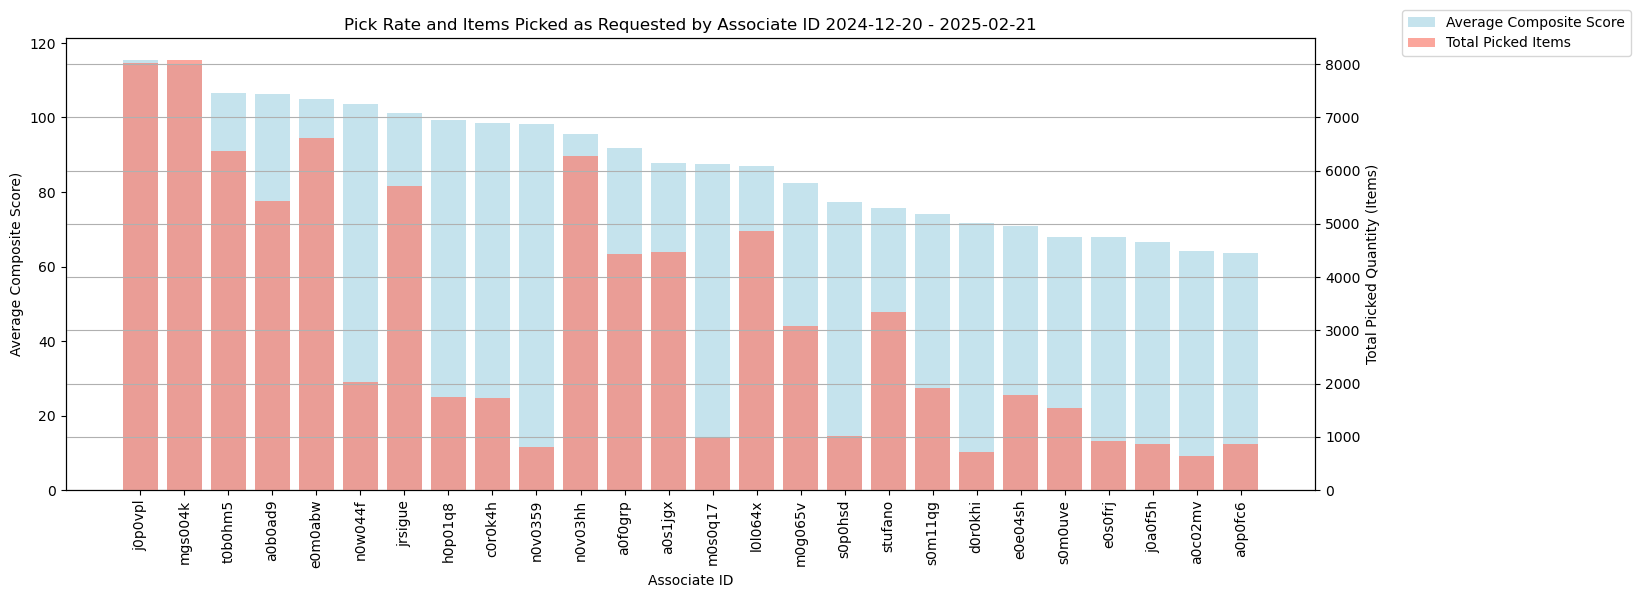

In [216]:

# Plotting side-by-side bar plot for average Composite Score and total Picked As Req Qty
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Composite_Score'] = pd.to_numeric(df['Composite_Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'Composite_Score'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_composite_score = df_clean.groupby('Associate ID')['Composite_Score'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate ID')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert Associate ID index to string for plotting
avg_composite_score.index = avg_composite_score.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_composite_score.index, avg_composite_score, color='lightblue', alpha=0.7, label='Average Composite Score')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average Composite Score)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


<h2>Compare Associate Composite Score WTD to Average</h2>

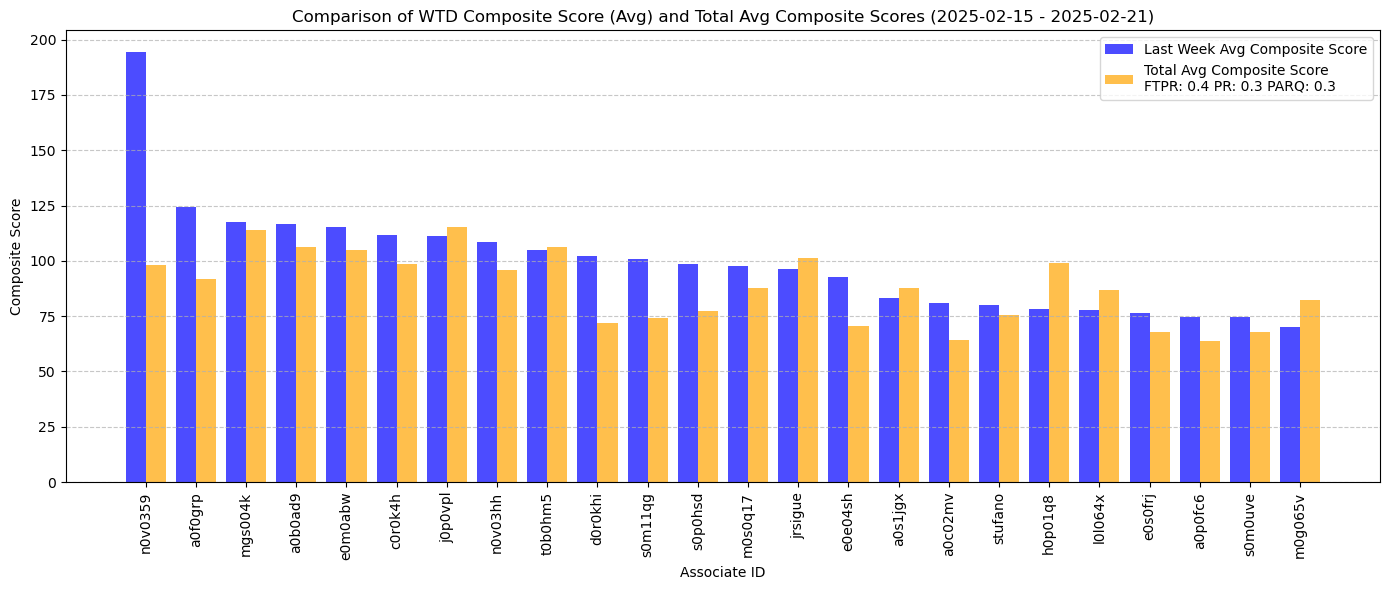

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Define function to find the most recent full week
def get_last_full_week(df):
    """Returns the dataframe filtered for the most recent full week along with the week range."""
    last_full_week_start = df['Custom Week Start'].max()  # Start of the most recent full week
    last_full_week_end = df['Custom Week End'].max()  # End of the most recent full week

    # Filter for the most recent full week
    filtered_df = df[
        (df['Day of Pick Date'] >= last_full_week_start) &
        (df['Day of Pick Date'] <= last_full_week_end)
    ].copy()

    return filtered_df, last_full_week_start, last_full_week_end

# Step 2: Filter data for the most recent full week and get the week range
most_recent_week_data, last_full_week_start, last_full_week_end = get_last_full_week(df_clean)

# Fill NaN values in Composite_Score and filter out associates with a score of 0
most_recent_week_data.loc[:, 'Composite_Score'] = most_recent_week_data['Composite_Score'].fillna(0)
most_recent_week_data = most_recent_week_data[most_recent_week_data['Composite_Score'] > 0]

# Step 3: Calculate last week's and total average Composite Score (only for associates present last week)
last_week_avg_composite_score = (
    most_recent_week_data.groupby(['Associate ID'])['Composite_Score']
    .mean()
)

# Filter df_clean to include only associates who had a score last week
df_clean_filtered = df_clean[df_clean['Associate ID'].isin(last_week_avg_composite_score.index)]

# Compute total average Composite Score (only for associates in last_week_avg_composite_score)
total_avg_composite_score = (
    df_clean_filtered.groupby(['Associate ID'])['Composite_Score']
    .mean()
)

# Step 4: Merge both metrics into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': last_week_avg_composite_score,
    'Total Avg Composite Score': total_avg_composite_score
})
comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 5: Plot comparison of last week's and total average Composite Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Create side-by-side bar plot
width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x],
    comparison_df['Last Week Avg Composite Score'],
    width=width,
    label='Last Week Avg Composite Score',
    color='blue',
    alpha=0.7
)
ax.bar(
    [pos + width / 2 for pos in x],
    comparison_df['Total Avg Composite Score'],
    width=width,
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}',
    color='orange',
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Associate ID')
ax.set_ylabel('Composite Score')
ax.set_title(f'Comparison of WTD Composite Score (Avg) and Total Avg Composite Scores ({last_full_week_start.date()} - {last_full_week_end.date()})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2></h2>

<h2>Composite Score Comparison LW (full week) to Average</h2>

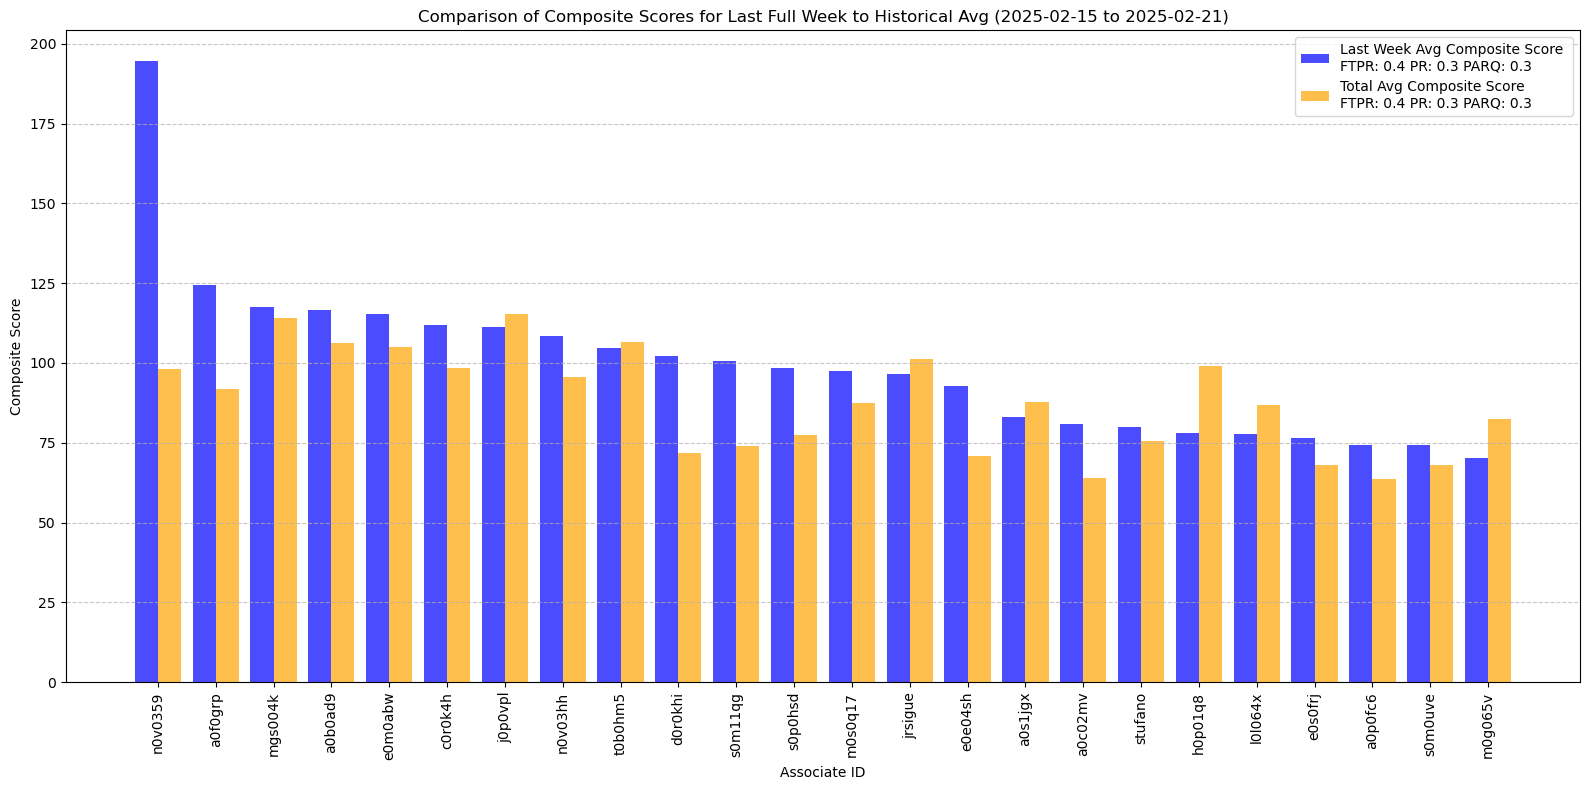

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent full week

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Step 5: Filter associates with Composite_Score > 0
last_week_data = last_week_data[last_week_data['Composite_Score'] > 0]

# Fill NaN values in 'Composite_Score' (if any)
last_week_data['Composite_Score'] = last_week_data['Composite_Score'].fillna(0)

# Step 6: Group by Associate ID and calculate average Composite Score for the last week
avg_composite_score_last_week = (
    last_week_data.groupby('Associate ID')['Composite_Score']
    .mean()
    .sort_values(ascending=False)
)

# Step 7: Filter total average Composite Score to include only IDs in last_week_data
associate_ids_last_week = last_week_data['Associate ID'].unique()  # Get unique Associate IDs from last_week_data
total_avg_composite_score = (
    df[df['Composite_Score'] > 0]
    .groupby('Associate ID')['Composite_Score']
    .mean()
    .loc[associate_ids_last_week]  # Filter to include only Associate IDs from last_week_data
)

# Step 8: Merge both scores into a single DataFrame for proper alignment
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': avg_composite_score_last_week,
    'Total Avg Composite Score': total_avg_composite_score
}).fillna(0)

comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 9: Visualization - Side-by-side bar chart
fig, ax = plt.subplots(figsize=(16, 8))

width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x], 
    comparison_df['Last Week Avg Composite Score'], 
    width=width, 
    label=f'Last Week Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='blue', 
    alpha=0.7
)

ax.bar(
    [pos + width / 2 for pos in x], 
    comparison_df['Total Avg Composite Score'], 
    width=width, 
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='orange', 
    alpha=0.7
)

# Set labels and title
ax.set_xlabel('Associate ID')
ax.set_ylabel(f'Composite Score')
ax.set_title(f'Comparison of Composite Scores for Last Full Week to Historical Avg ({last_full_week})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


<h2>Comparison of Composite Score MTD compared to Last Month</h2>

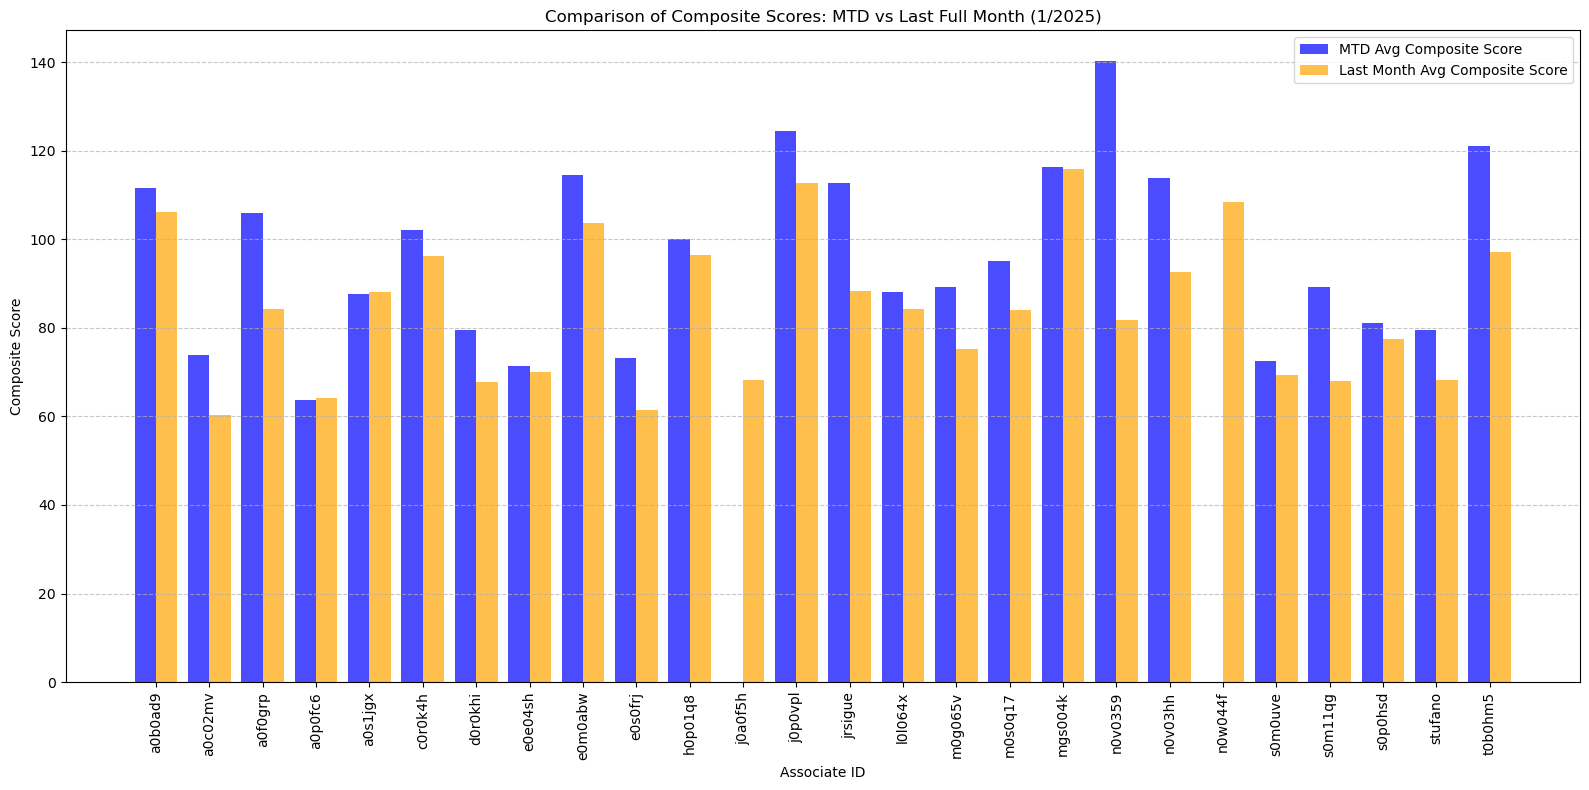

In [219]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get the current date and define month-to-date (MTD) and last full month
#today = pd.to_datetime("2025-01-31")
today = pd.to_datetime("today")
current_month = today.month
current_year = today.year

# Define last full month
if current_month == 1:
    last_month = 12
    last_month_year = current_year - 1
else:
    last_month = current_month - 1
    last_month_year = current_year

# Step 2: Filter data for MTD and last full month
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format

# Month-to-Date (MTD) data
mtd_data = df[
    (df['Day of Pick Date'].dt.year == current_year) & 
    (df['Day of Pick Date'].dt.month == current_month) & 
    (df['Composite_Score'] > 0)
]

# Last full month data
last_month_data = df[
    (df['Day of Pick Date'].dt.year == last_month_year) & 
    (df['Day of Pick Date'].dt.month == last_month) & 
    (df['Composite_Score'] > 0)
]

# Step 3: Compute average composite scores for each Associate
avg_composite_score_mtd = mtd_data.groupby('Associate ID')['Composite_Score'].mean()
avg_composite_score_last_month = last_month_data.groupby('Associate ID')['Composite_Score'].mean()

is_empty = mtd_data['Composite_Score'].count() == 0
# Step 4: Merge both scores into a single DataFrame for alignment
comparison_df = pd.DataFrame({
    'MTD Avg Composite Score': avg_composite_score_mtd,
    'Last Month Avg Composite Score': avg_composite_score_last_month
}).fillna(0)

if is_empty == True:
    print(f'No data for {current_month}/{current_year}')
else:
    # Step 5: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions
    
    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['MTD Avg Composite Score'], 
        width=width, 
        label='MTD Avg Composite Score', 
        color='blue', 
        alpha=0.7
    )
    
    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Last Month Avg Composite Score'], 
        width=width, 
        label='Last Month Avg Composite Score', 
        color='orange', 
        alpha=0.7
    )
    
    # Set labels and title
    ax.set_xlabel('Associate ID')
    ax.set_ylabel('Composite Score')
    ax.set_title(f'Comparison of Composite Scores: MTD vs Last Full Month ({last_month}/{last_month_year})')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)
    
    # Add a legend
    ax.legend()
    
    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


<h2>Total Performance By Selected Month by Associate</h2>

  Associate ID  Year  Month  Week of Month       FTPR  Pick Rate  Pick Hours  Qty Req to Pick  Picked As Req Qty  Substitution Qty  Nil Pick Qty  Exception Qty Req to Pick
0      a0b0ad9  2024     12              4  98.530000  29.000000    4.670000            138.0                134                 3             2                          0
1      a0b0ad9  2024     12              5  95.352500  52.500000    3.355000            630.0                599                10            10                          2
2      a0b0ad9  2025      1              1  96.746667  55.333333    4.670000            795.0                771                15             8                          4
3      a0b0ad9  2025      1              2  96.806667  47.000000    3.603333            516.0                498                 7            14                          9
4      a0b0ad9  2025      1              3  96.330000  45.000000    3.690000            697.0                662                14          

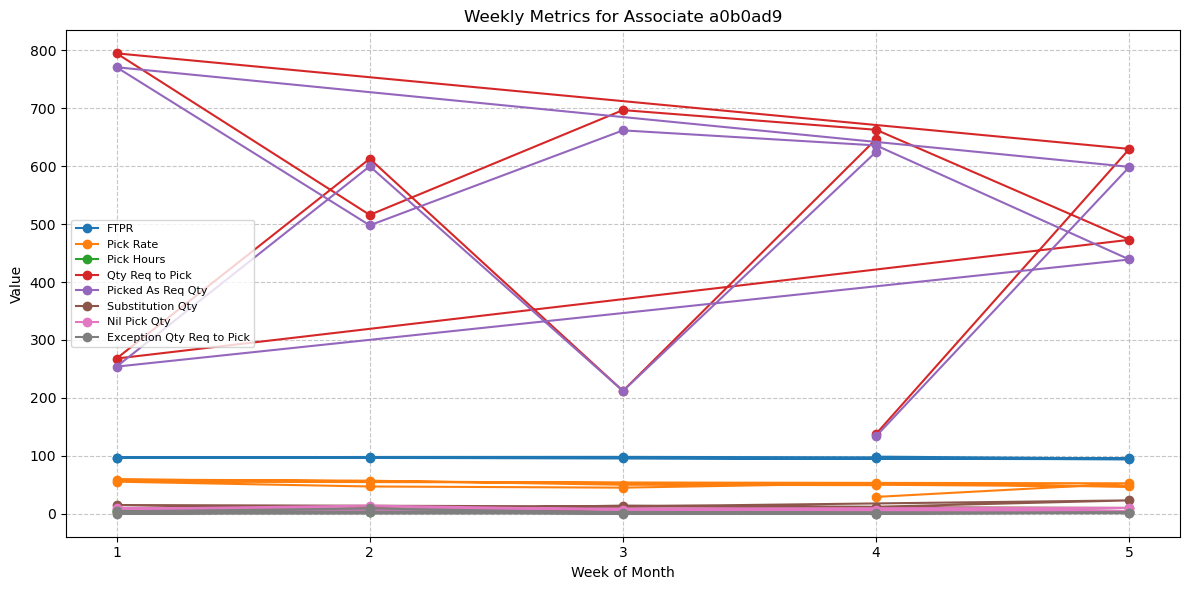

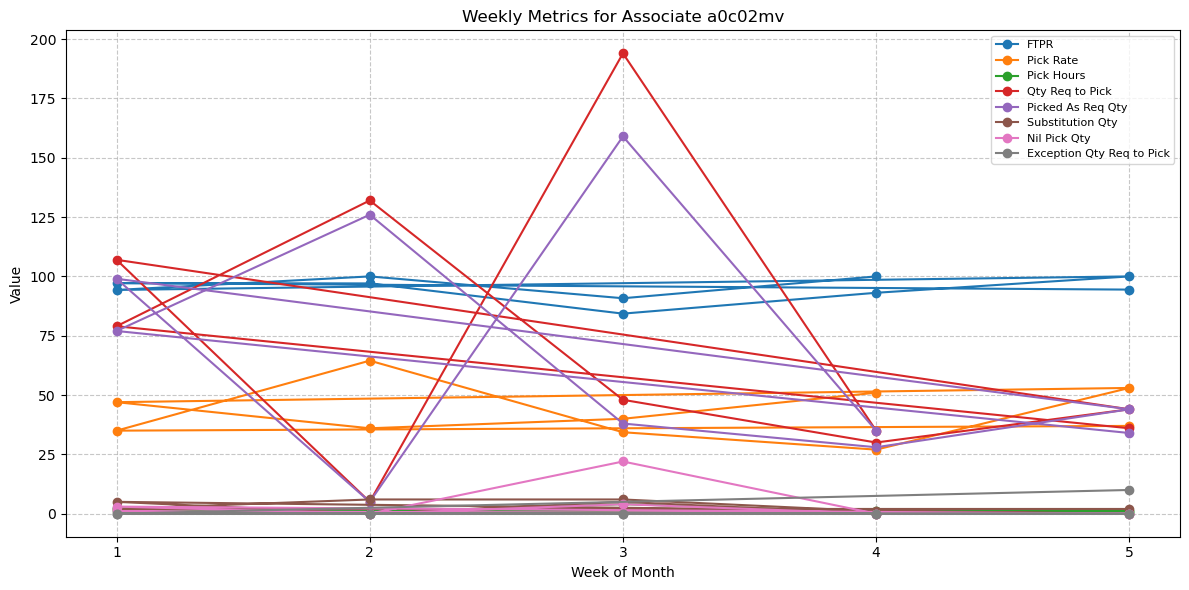

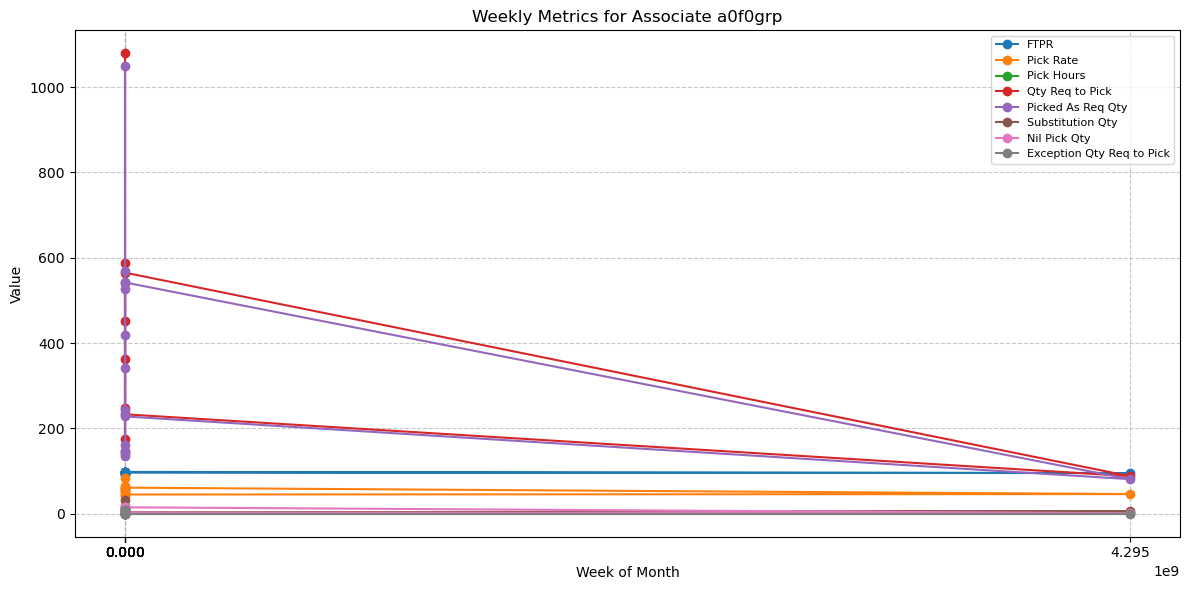

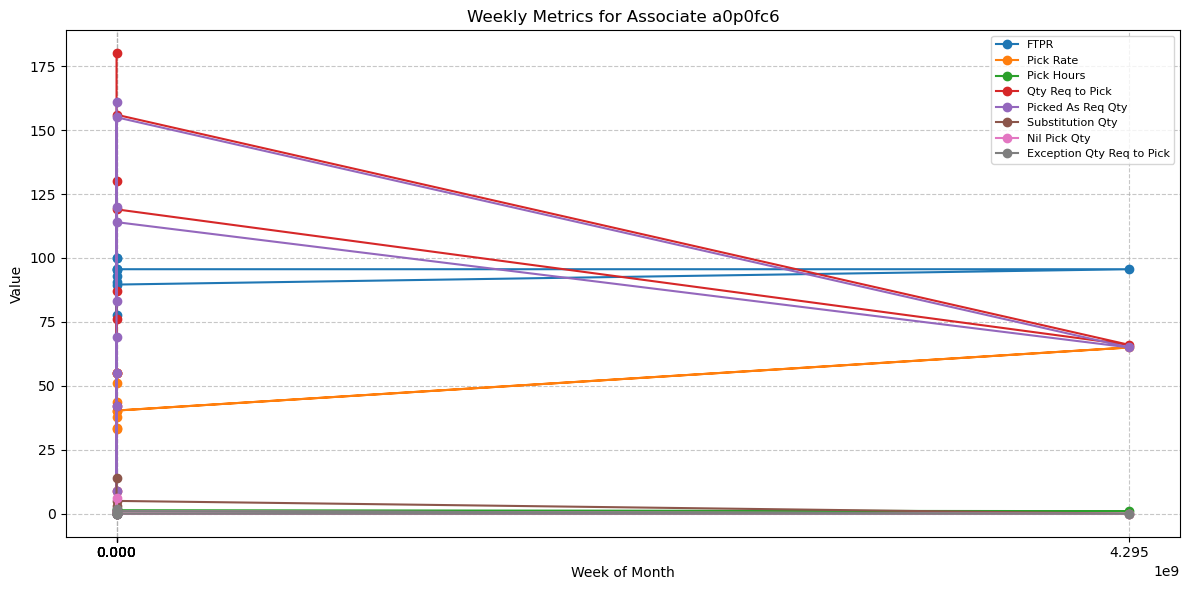

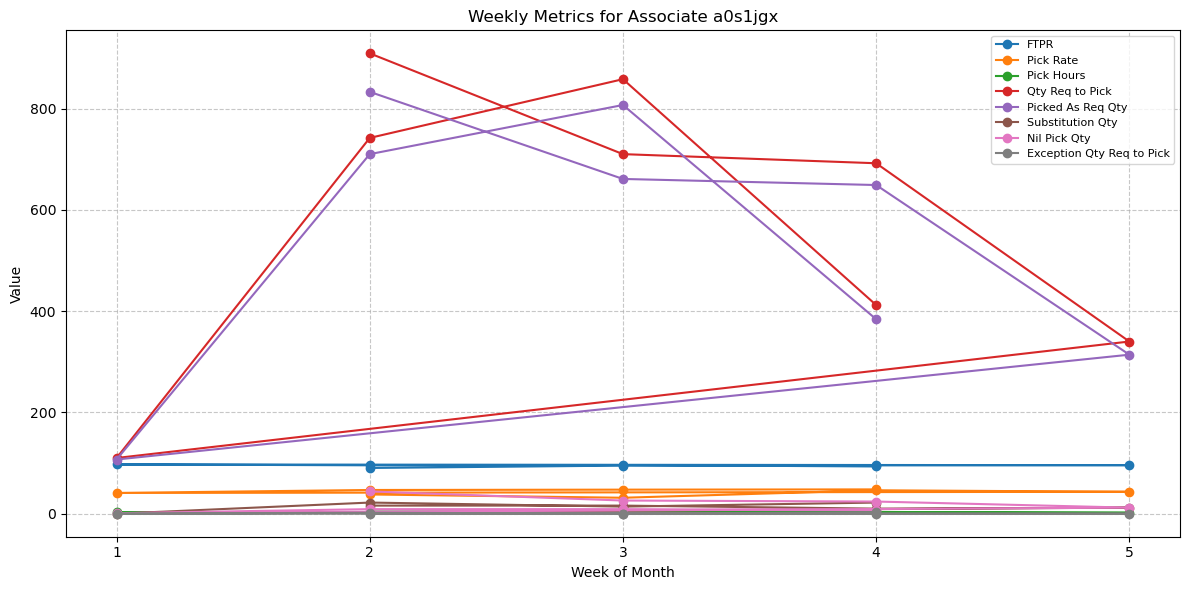

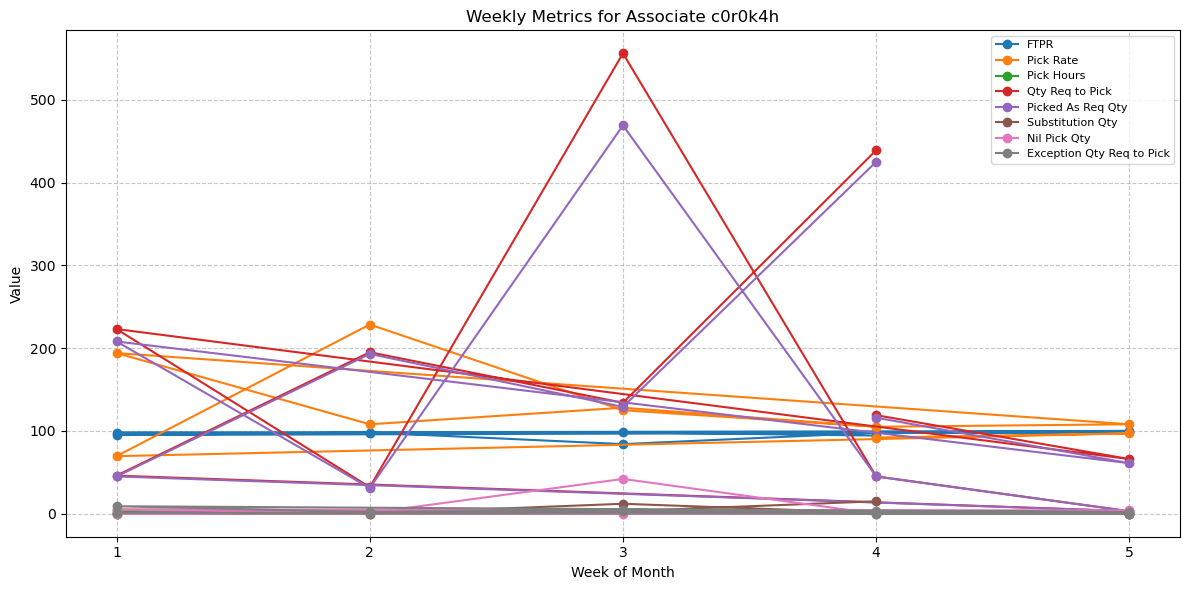

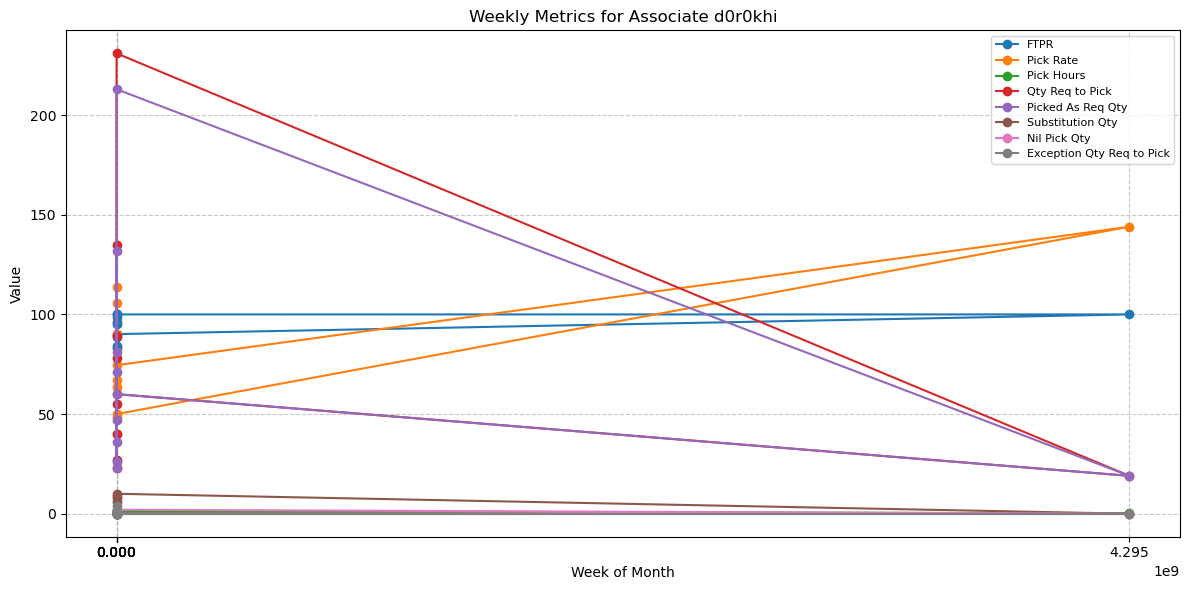

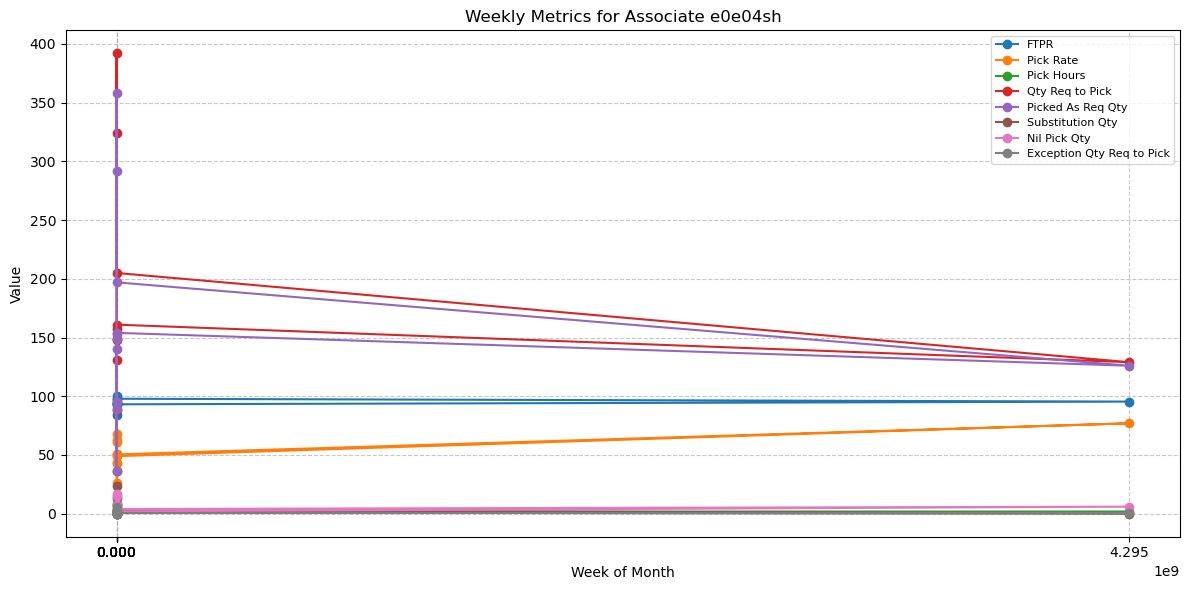

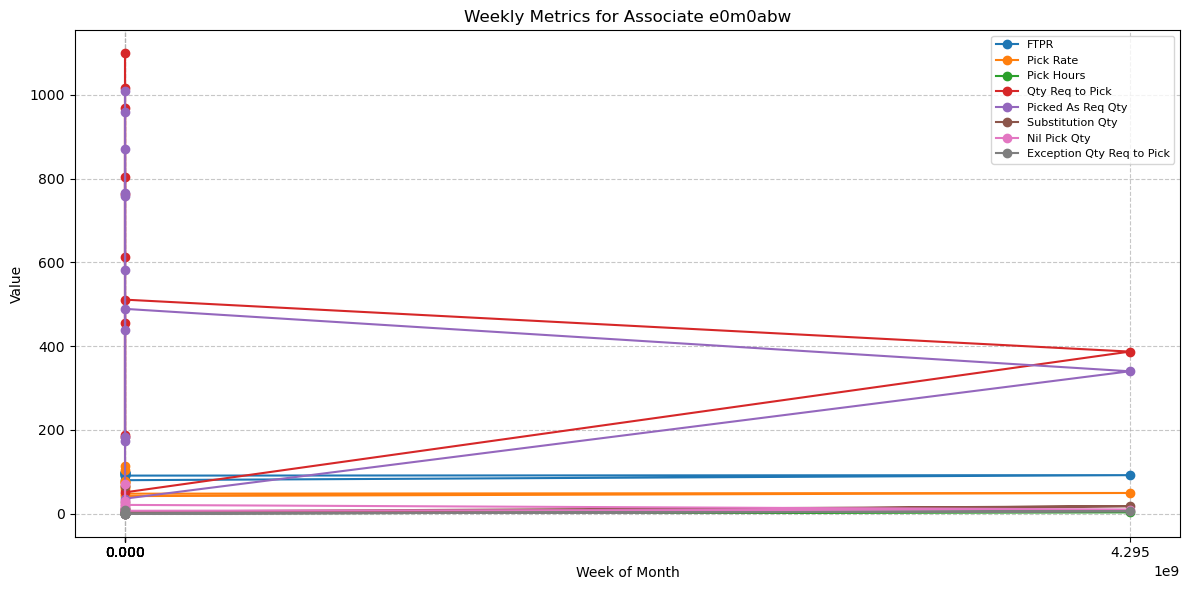

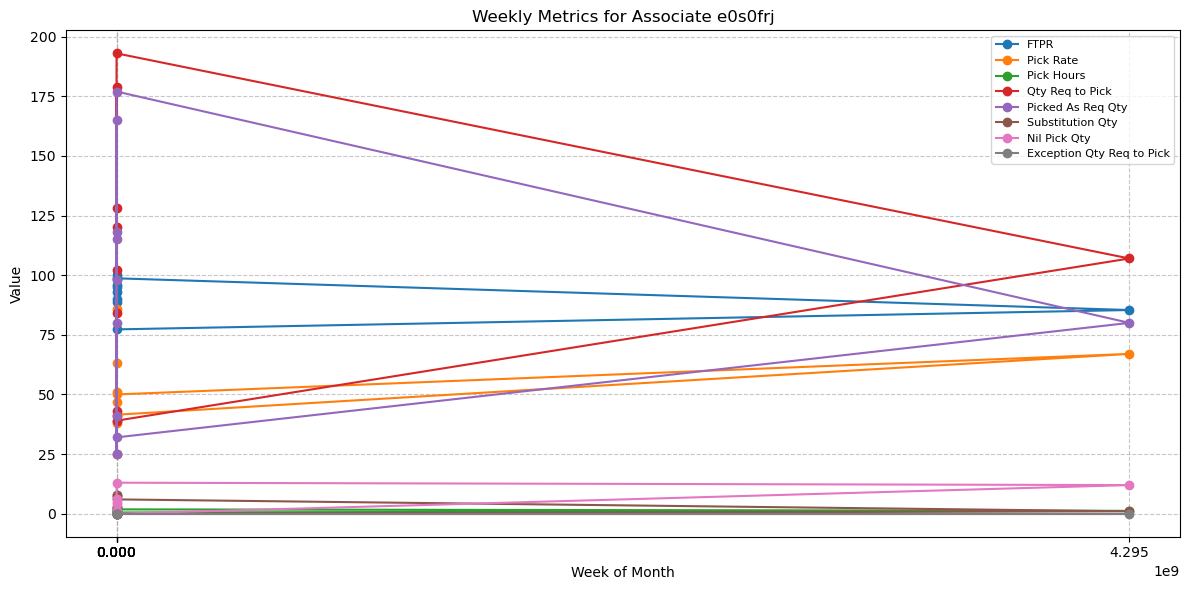

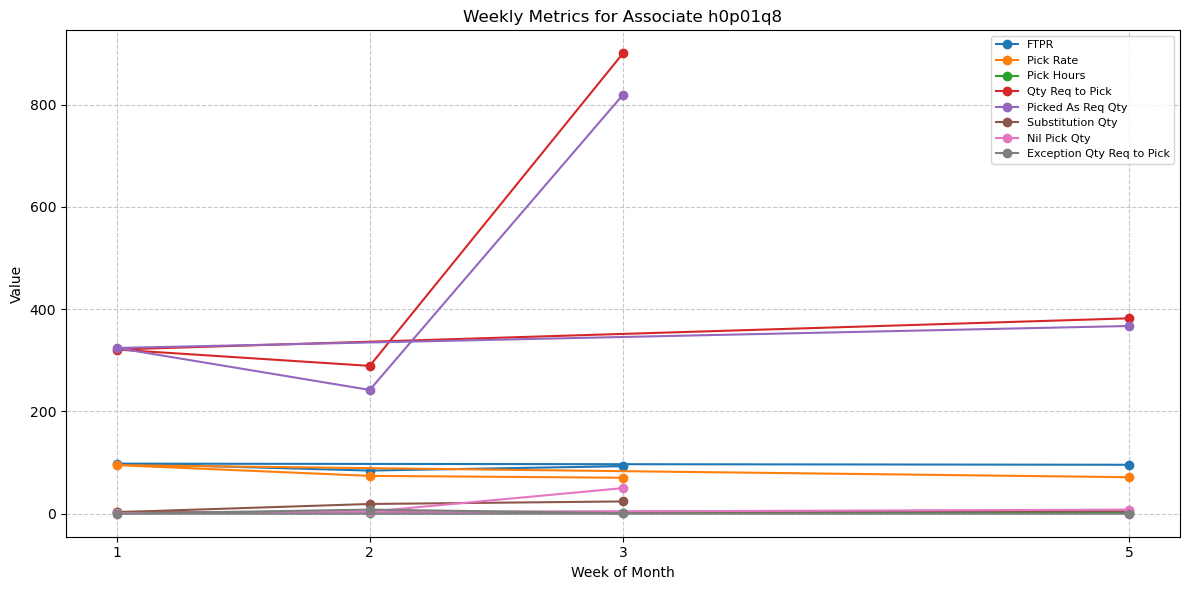

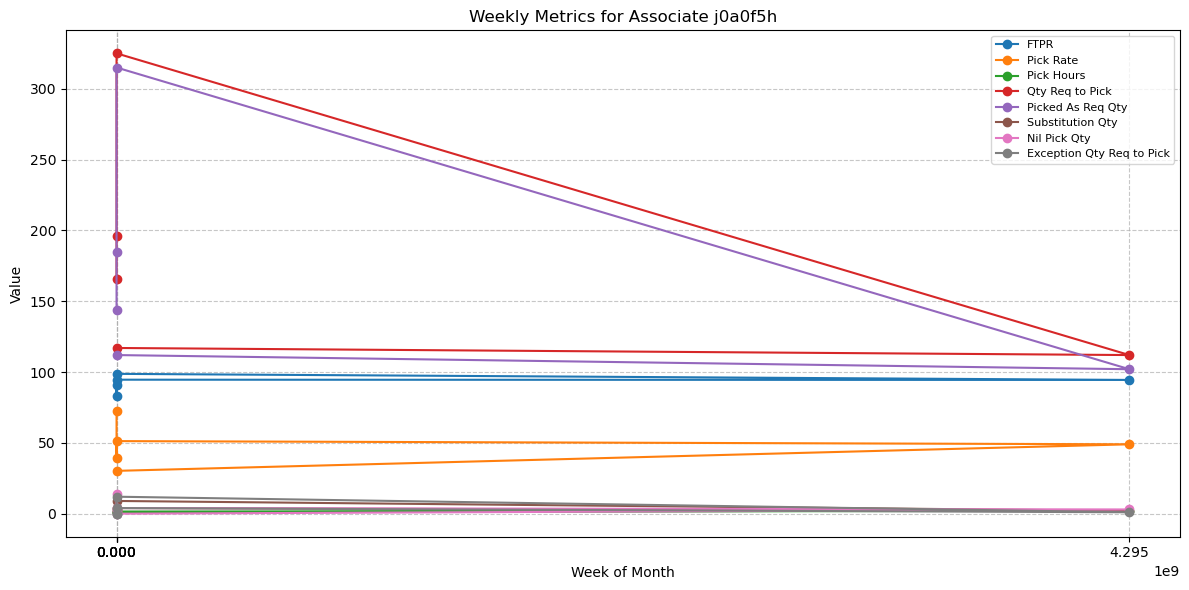

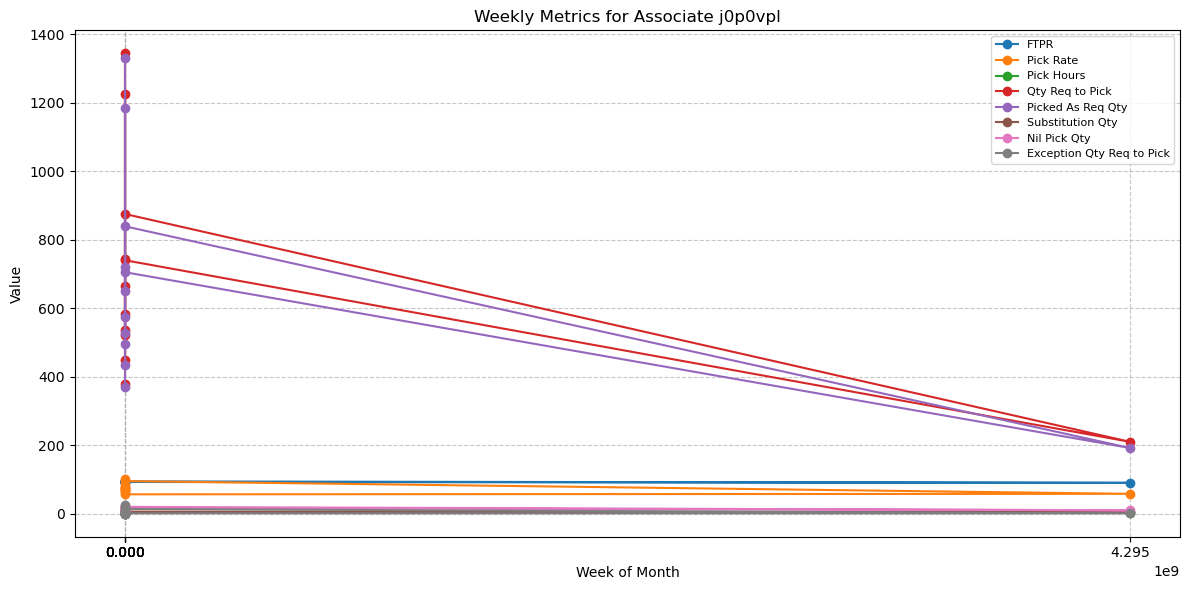

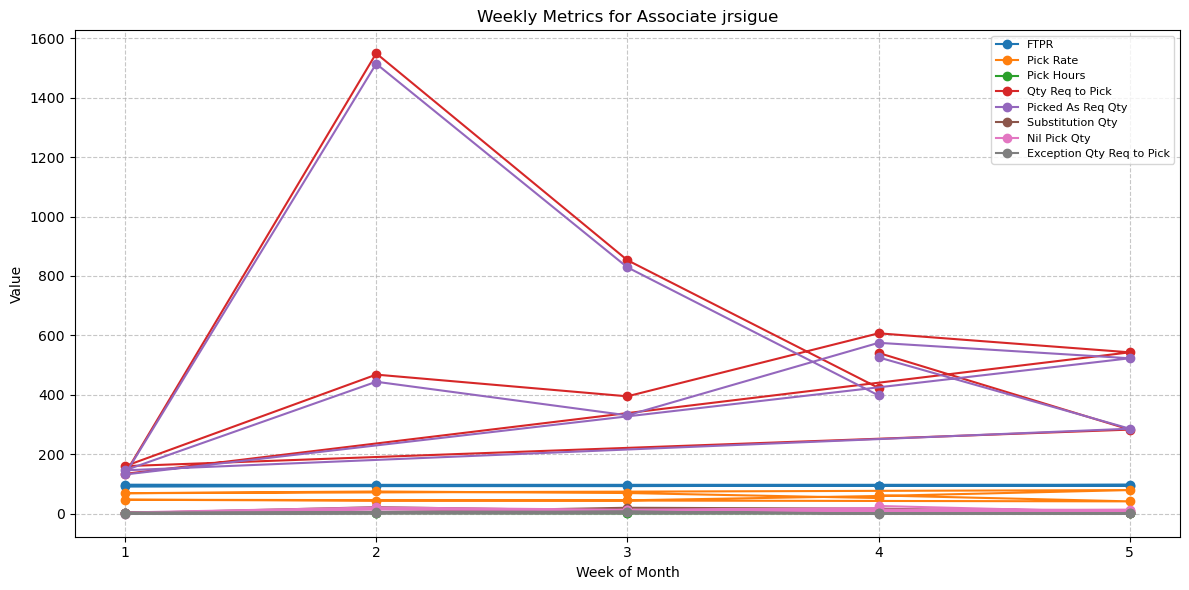

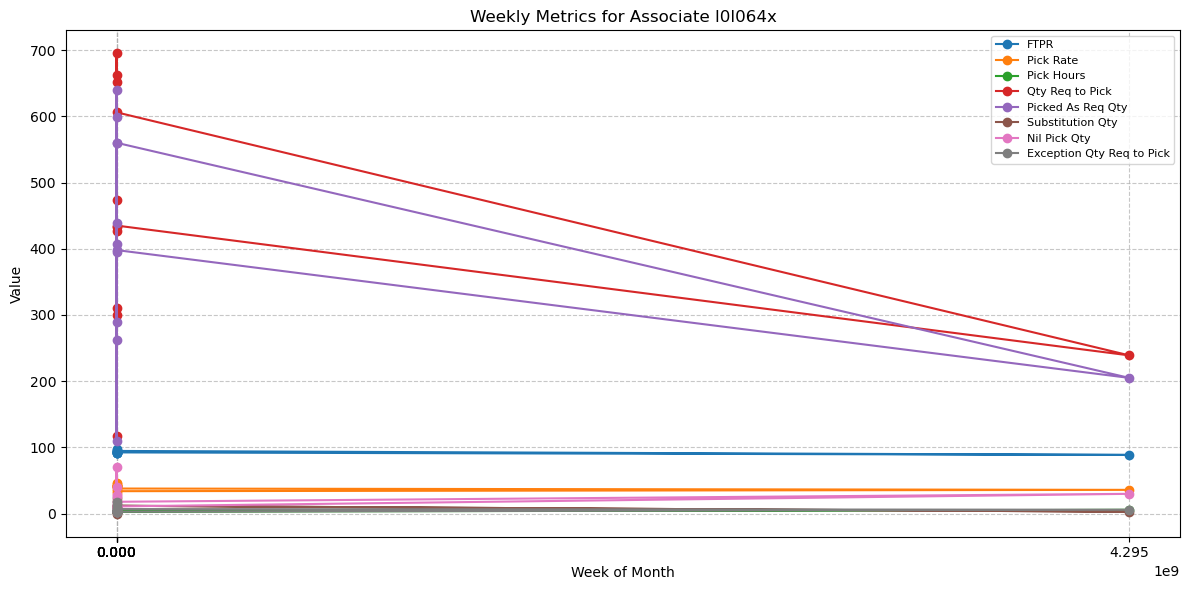

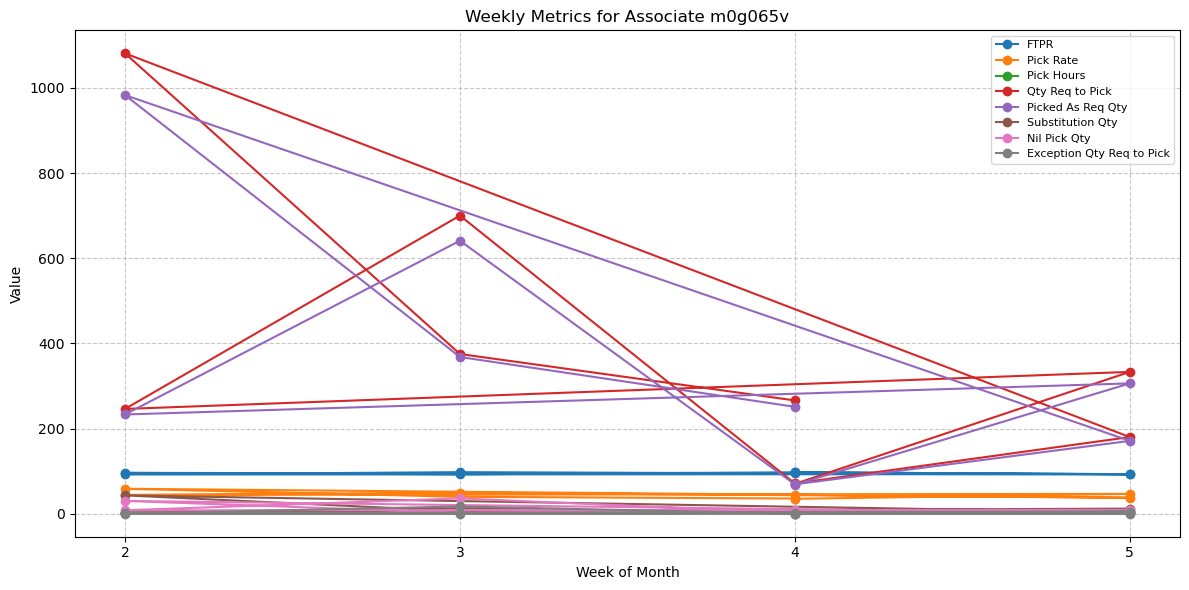

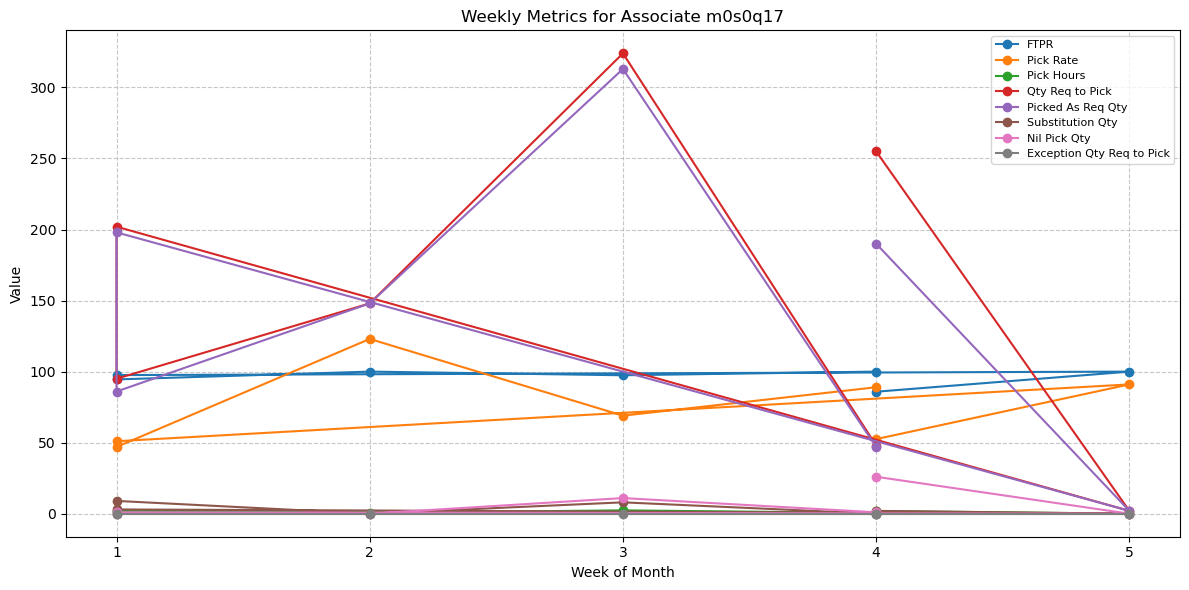

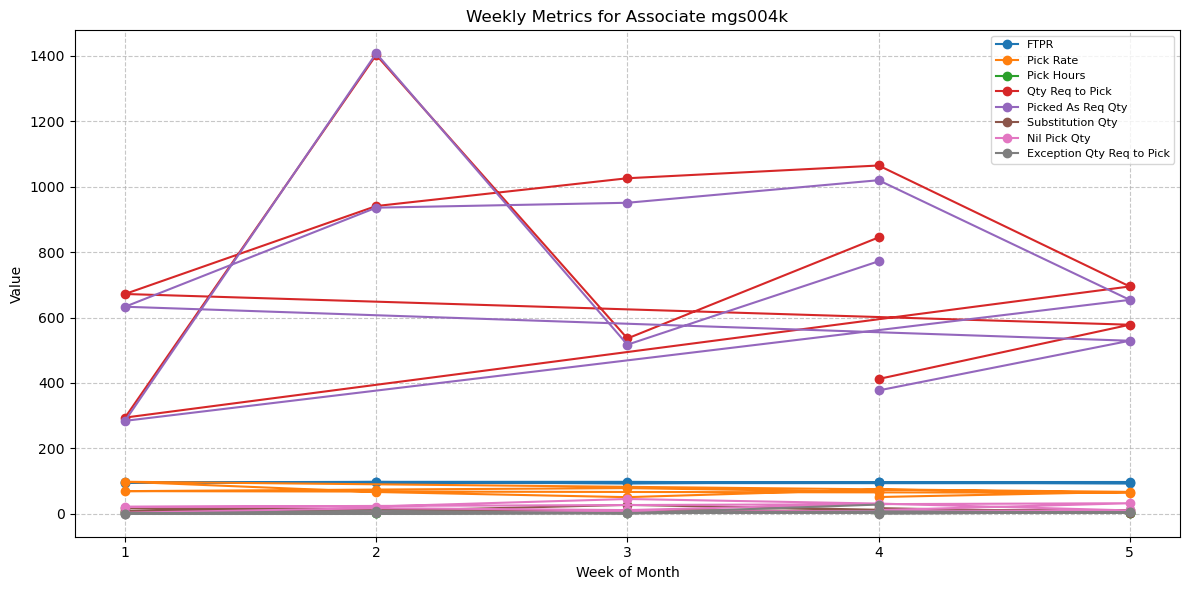

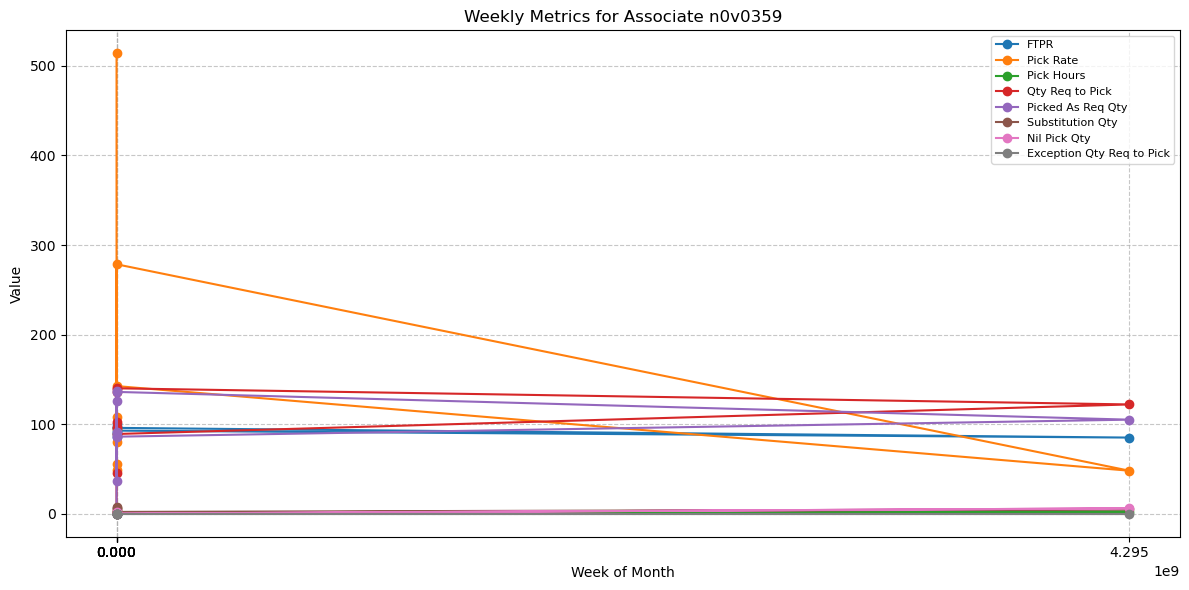

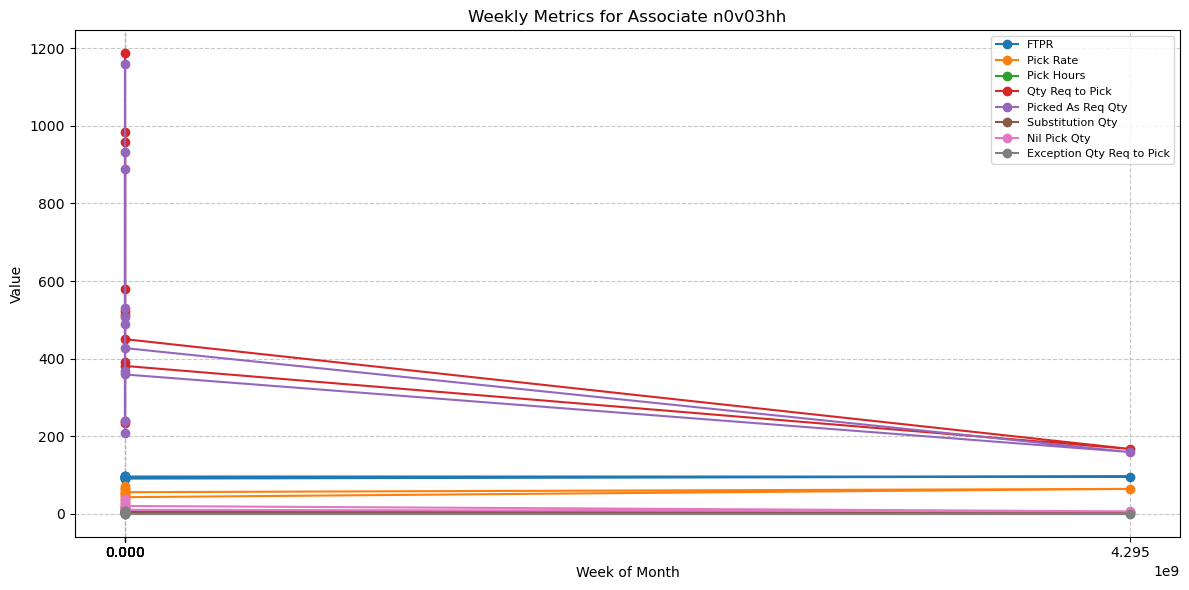

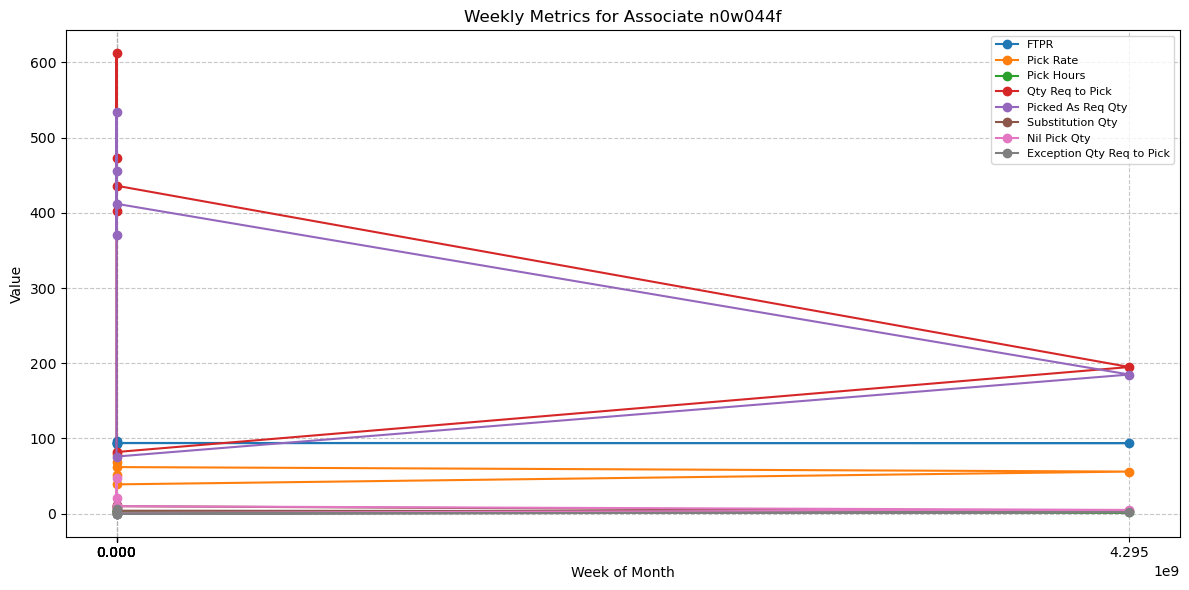

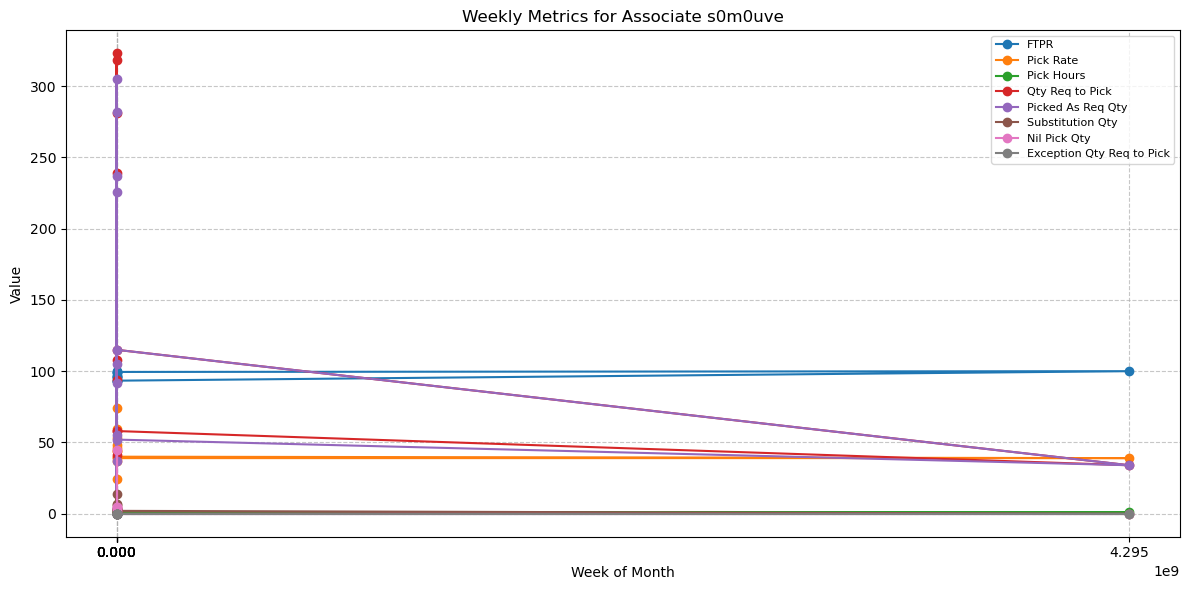

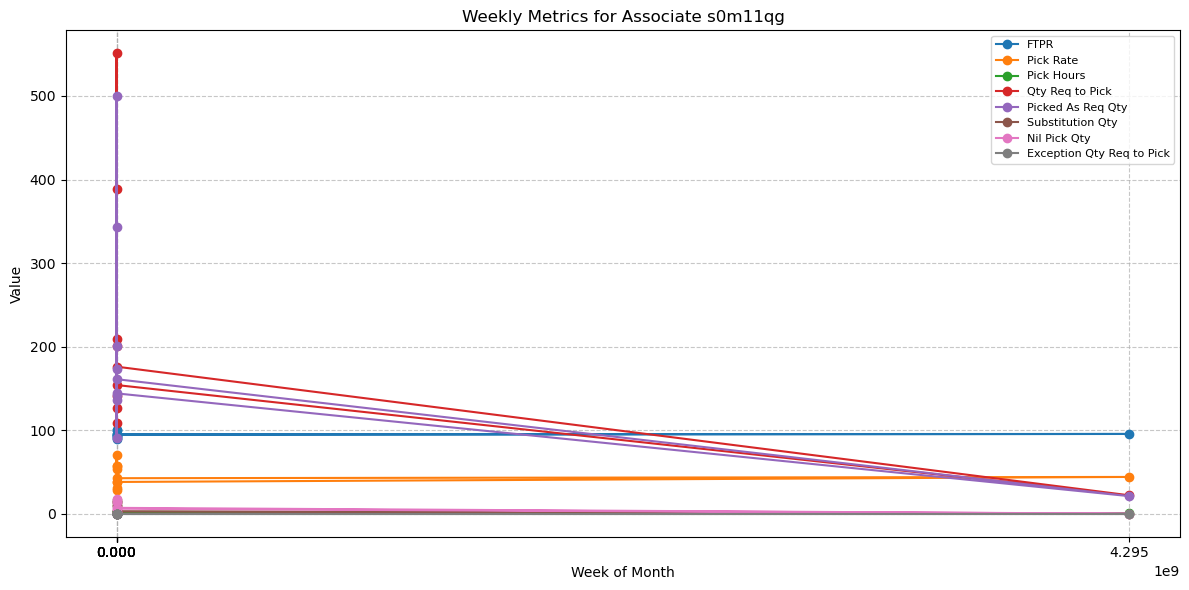

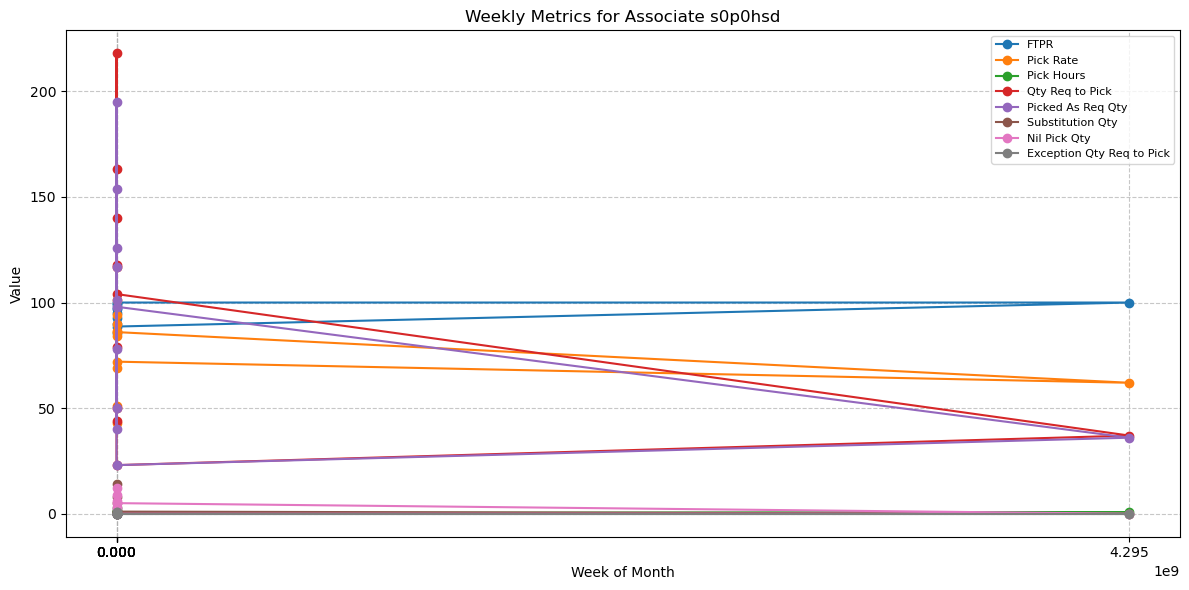

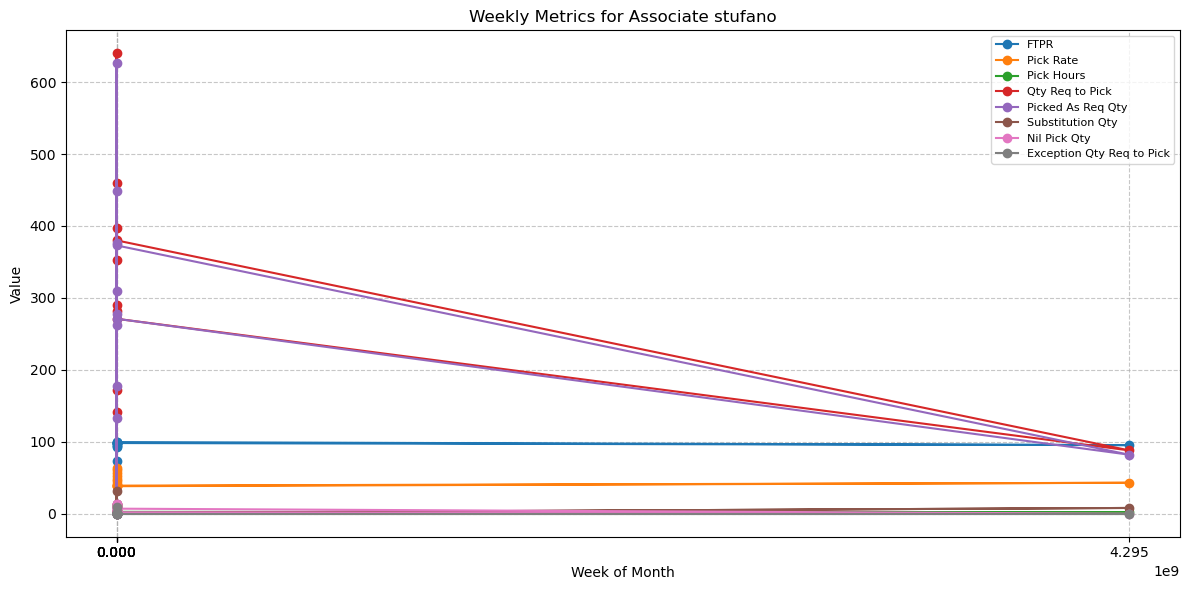

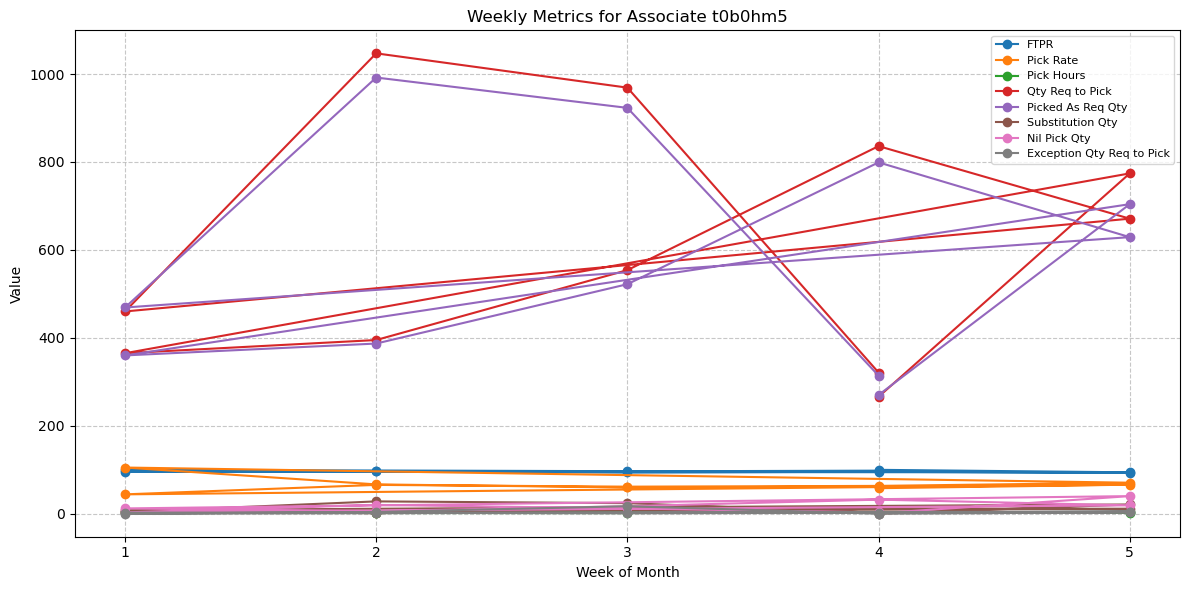

In [220]:
# Extract Year, Month
df['Year'] = df['Day of Pick Date'].dt.year
df['Month'] = df['Day of Pick Date'].dt.month

# Compute the first day of the month for each row
df['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))

# Compute the week number of the first day of the month
df['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week

# Compute the actual week of the month
df['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1

# Define the metrics and their aggregation type
metrics_agg = {
    'FTPR': 'mean',  # Average
    'Pick Rate': 'mean',  
    'Pick Hours': 'mean',  
    'Qty Req to Pick': 'sum',  # Sum
    'Picked As Req Qty': 'sum',
    'Substitution Qty': 'sum',
    'Nil Pick Qty': 'sum',
    'Exception Qty Req to Pick': 'sum'
}

# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions
weekly_aggregated = df.groupby(['Associate ID', 'Year', 'Month', 'Week of Month'], as_index=False).agg(metrics_agg)

# Filter to ensure no previous month’s data spills over
weekly_aggregated = weekly_aggregated[weekly_aggregated['Week of Month'] > 0]

# Sort for proper plotting
weekly_aggregated = weekly_aggregated.sort_values(by=['Associate ID', 'Year', 'Month', 'Week of Month'])

# Debugging Step: Check if the grouping is correct
print(weekly_aggregated.head(10))  # Print first 10 rows to verify correctness

# Generate individual plots for each Associate
for associate in weekly_aggregated['Associate ID'].unique():
    associate_data = weekly_aggregated[weekly_aggregated['Associate ID'] == associate]

    plt.figure(figsize=(12, 6))

    # Plot each metric as a separate line
    for metric in metrics_agg.keys():
        plt.plot(associate_data['Week of Month'], associate_data[metric], marker='o', linestyle='-', label=metric)

    plt.xlabel('Week of Month')
    plt.ylabel('Value')
    plt.title(f'Weekly Metrics for Associate {associate}')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(associate_data['Week of Month'].unique())  # Ensure proper x-axis labels
    plt.tight_layout()
    
    plt.show()


<h1>disregard the models below for now as of 1/28/2025</h1>

<h2>Using PyTorch (mps) to make a model that predicts FTPR, Pick Rate, Picked As Req Qty</h2>

In [221]:
# Load and preprocess data
# Assuming 'df' is the provided DataFrame
#df = df.copy()
features = ['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate', 'Picked As Req Qty']

X = df[features].values
y = df[targets].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network
class MultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = len(features)
output_dim = len(targets)
model = MultiOutputRegression(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

    train_mse = mean_squared_error(y_train, y_pred_train.numpy())
    test_mse = mean_squared_error(y_test, y_pred_test.numpy())

    train_r2 = r2_score(y_train, y_pred_train.numpy())
    test_r2 = r2_score(y_test, y_pred_test.numpy())

print("Training Metrics:")
print(f"MSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print("Testing Metrics:")
print(f"MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")


Epoch [10/100], Loss: 11431.7910
Epoch [20/100], Loss: 11315.3105
Epoch [30/100], Loss: 11119.0205
Epoch [40/100], Loss: 10800.9561
Epoch [50/100], Loss: 10315.2314
Epoch [60/100], Loss: 9623.7002
Epoch [70/100], Loss: 8715.1260
Epoch [80/100], Loss: 7630.1313
Epoch [90/100], Loss: 6465.0420
Epoch [100/100], Loss: 5344.8364
Training Metrics:
MSE: 5239.8725, R2 Score: -33.6319
Testing Metrics:
MSE: 4939.9068, R2 Score: -25.4644


In [222]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

start_time = time.time()
# Define the model architecture with dropout for regularization
class EnhancedMultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedMultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Assume df is your dataframe and contains the necessary columns
# Features and targets
features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
            'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate']

X = df[features].values
y = df[targets].values

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss Function, Optimizer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = EnhancedMultiOutputRegression(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Evaluating the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

# Reverse scaling to compute metrics
y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

y_train_rescaled = target_scaler.inverse_transform(y_train)
y_test_rescaled = target_scaler.inverse_transform(y_test)

train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

end_time = time.time()
# Print metrics
print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
print(f'Total time: {end_time - start_time}')


Epoch [10/100], Loss: 0.6072
Epoch [20/100], Loss: 0.4576
Epoch [30/100], Loss: 0.4294
Epoch [40/100], Loss: 0.4214
Epoch [50/100], Loss: 0.4283
Epoch [60/100], Loss: 0.4277
Epoch [70/100], Loss: 0.4392
Epoch [80/100], Loss: 0.4140
Epoch [90/100], Loss: 0.4262
Epoch [100/100], Loss: 0.4443
Training Metrics:
MSE: 296.0024, R2 Score: 0.5750
Testing Metrics:
MSE: 213.5301, R2 Score: 0.4239
Total time: 0.944857120513916


In [223]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model architecture with dropout for regularization
class EnhancedMultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedMultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
        self.fc2 = nn.Linear(128, 256)              # Second hidden layer
        self.fc3 = nn.Linear(256, 128)              # Third hidden layer
        self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
        self.fc5 = nn.Linear(64, output_dim)        # Output layer
        self.relu = nn.ReLU()                       # ReLU activation
        self.dropout = nn.Dropout(0.3)              # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))                  # Pass through first layer
        x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
        x = self.relu(self.fc3(x))                  # Pass through third layer
        x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
        x = self.fc5(x)                             # Output layer
        return x

# Features and target columns
features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
            'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate']

# Prepare data
X = df[features].values
y = df[targets].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Convert data to PyTorch tensors and move to the specified device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss Function, Optimizer, and Scheduler
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

# Training the model with validation loss and early stopping
num_epochs = 100
patience, early_stop_counter = 10, 0  # Early stopping patience
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
model.eval()

# Evaluate on training and testing sets
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Reverse scaling to compute metrics
y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

y_train_rescaled = target_scaler.inverse_transform(y_train)
y_test_rescaled = target_scaler.inverse_transform(y_test)

train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

end_time = time.time()

# Print metrics
print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


Using device: mps
Epoch [1/100], Train Loss: 0.9158, Val Loss: 0.9068
Epoch [2/100], Train Loss: 0.8100, Val Loss: 0.8911
Epoch [3/100], Train Loss: 0.7820, Val Loss: 0.9463
Epoch [4/100], Train Loss: 0.6776, Val Loss: 0.7183
Epoch [5/100], Train Loss: 0.6841, Val Loss: 0.7368
Epoch [6/100], Train Loss: 0.5963, Val Loss: 0.6645
Epoch [7/100], Train Loss: 0.6205, Val Loss: 0.7352
Epoch [8/100], Train Loss: 0.5981, Val Loss: 0.9572
Epoch [9/100], Train Loss: 0.5801, Val Loss: 0.6495
Epoch [10/100], Train Loss: 0.5625, Val Loss: 0.7399
Epoch [11/100], Train Loss: 0.6626, Val Loss: 0.8371
Epoch [12/100], Train Loss: 0.5925, Val Loss: 0.6836
Epoch [13/100], Train Loss: 0.7646, Val Loss: 0.7079
Epoch [14/100], Train Loss: 0.6430, Val Loss: 1.0747
Epoch [15/100], Train Loss: 0.5677, Val Loss: 0.7293
Epoch [16/100], Train Loss: 0.5350, Val Loss: 0.5911
Epoch [17/100], Train Loss: 0.4986, Val Loss: 0.6757
Epoch [18/100], Train Loss: 0.6507, Val Loss: 0.7084
Epoch [19/100], Train Loss: 0.5505, V

In [224]:
# Check device
device = torch.device("cpu")
print(f"Using device: {device}")

# Define the model architecture with dropout for regularization
class EnhancedMultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedMultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
        self.fc2 = nn.Linear(128, 256)              # Second hidden layer
        self.fc3 = nn.Linear(256, 128)              # Third hidden layer
        self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
        self.fc5 = nn.Linear(64, output_dim)        # Output layer
        self.relu = nn.ReLU()                       # ReLU activation
        self.dropout = nn.Dropout(0.3)              # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))                  # Pass through first layer
        x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
        x = self.relu(self.fc3(x))                  # Pass through third layer
        x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
        x = self.fc5(x)                             # Output layer
        return x

# Features and target columns
features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
            'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate']

# Prepare data
X = df[features].values
y = df[targets].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Convert data to PyTorch tensors and move to the specified device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss Function, Optimizer, and Scheduler
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

# Training the model with validation loss and early stopping
num_epochs = 100
patience, early_stop_counter = 10, 0  # Early stopping patience
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
model.eval()

# Evaluate on training and testing sets
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Reverse scaling to compute metrics
y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

y_train_rescaled = target_scaler.inverse_transform(y_train)
y_test_rescaled = target_scaler.inverse_transform(y_test)

train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

end_time = time.time()

# Print metrics
print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


Using device: cpu
Epoch [1/100], Train Loss: 1.0298, Val Loss: 0.9708
Epoch [2/100], Train Loss: 0.8881, Val Loss: 0.8000
Epoch [3/100], Train Loss: 0.7424, Val Loss: 0.8272
Epoch [4/100], Train Loss: 0.7092, Val Loss: 0.7137
Epoch [5/100], Train Loss: 0.6790, Val Loss: 1.1293
Epoch [6/100], Train Loss: 0.8300, Val Loss: 0.8574
Epoch [7/100], Train Loss: 0.7447, Val Loss: 0.8323
Epoch [8/100], Train Loss: 0.6782, Val Loss: 0.7130
Epoch [9/100], Train Loss: 0.6282, Val Loss: 0.7533
Epoch [10/100], Train Loss: 0.6902, Val Loss: 0.9146
Epoch [11/100], Train Loss: 0.6476, Val Loss: 0.6798
Epoch [12/100], Train Loss: 0.5631, Val Loss: 0.6292
Epoch [13/100], Train Loss: 1.2742, Val Loss: 0.6633
Epoch [14/100], Train Loss: 0.6379, Val Loss: 0.7438
Epoch [15/100], Train Loss: 0.5564, Val Loss: 0.7518
Epoch [16/100], Train Loss: 0.5929, Val Loss: 0.7030
Epoch [17/100], Train Loss: 0.5807, Val Loss: 0.8389
Epoch [18/100], Train Loss: 0.5808, Val Loss: 0.7672
Epoch [19/100], Train Loss: 0.5543, V

<h2>Attempt to make PyTorch model better</h2>

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

# Define Models with More Complexity
class EnhancedModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Data Preparation (include interaction features or domain-specific knowledge)
df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
df['Total Exceptions'] = (
    df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
    df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
)

X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
        'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
        'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Function with Learning Rate Scheduling
def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Adjust learning rate based on validation loss
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

# Train and Evaluate Models
start_time = time.time()
input_size = X_train_scaled.shape[1]

# FTPR Model
ftpr_model = EnhancedModel(input_size)
optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
criterion = nn.MSELoss()
ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

# Pick Rate Model
pick_rate_model = EnhancedModel(input_size)
optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

# Picked As Req Qty Model
picked_as_req_qty_model = EnhancedModel(input_size)
optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
    picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
)

end_time = time.time()

# Results
print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


FTPR Prediction Metrics:
MSE: 53.3081, R2 Score: -0.1523
Pick Rate Prediction Metrics:
MSE: 155.6667, R2 Score: 0.8648
Picked As Req Qty Prediction Metrics:
MSE: 66.3817, R2 Score: 0.9898
Total time: 2.78 seconds


In [226]:
# Feature importance using Random Forest for FTPR
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model on FTPR to find important features
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train_ftpr)
importances = rf.feature_importances_

# Display feature importance
feature_importance = sorted(zip(importances, X.columns), reverse=True)
print("Feature Importance for FTPR:")
for importance, feature in feature_importance:
    print(f"{feature}: {importance:.4f}")

# Select top features based on importance
top_features = [feature for importance, feature in feature_importance if importance > 0.05]
X_train_ftpr = X_train_scaled[:, [X.columns.get_loc(f) for f in top_features]]
X_test_ftpr = X_test_scaled[:, [X.columns.get_loc(f) for f in top_features]]

# Use only these features in the FTPR model
ftpr_model = EnhancedModel(len(top_features))


Feature Importance for FTPR:
Picked As Req Qty: 0.2576
Pick Hours per Qty Req: 0.1990
Nil Pick Qty: 0.1863
Substitution Qty: 0.1209
Qty Req to Pick: 0.0982
Pick Hours: 0.0772
Exception Substitution Qty: 0.0172
Exception Qty Req to Pick: 0.0146
Exception Nil Pick Qty: 0.0143
Total Exceptions: 0.0130
Exception Picked As Req Qty: 0.0016


In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

# Define Models with More Complexity
class EnhancedModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Data Preparation based on Feature Importance
df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
df['Total Exceptions'] = (
    df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
    df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
)

# Selecting features based on importance
X = df[['Picked As Req Qty', 'Pick Hours per Qty Req', 'Nil Pick Qty', 'Qty Req to Pick', 
        'Substitution Qty', 'Pick Hours', 'Total Exceptions']]  # Focus on important features

y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Function with Learning Rate Scheduling
def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Adjust learning rate based on validation loss
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

# Train and Evaluate Models
start_time = time.time()
input_size = X_train_scaled.shape[1]

# FTPR Model
ftpr_model = EnhancedModel(input_size)
optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
criterion = nn.MSELoss()
ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

# Pick Rate Model
pick_rate_model = EnhancedModel(input_size)
optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

# Picked As Req Qty Model
picked_as_req_qty_model = EnhancedModel(input_size)
optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
    picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
)

end_time = time.time()

# Results
print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")

# Feature Importance based on your provided data
# These are the feature importance scores for FTPR as an example
feature_importance = {
    'Picked As Req Qty': 0.2553,
    'Pick Hours per Qty Req': 0.1751,
    'Nil Pick Qty': 0.1545,
    'Qty Req to Pick': 0.1504,
    'Substitution Qty': 0.1096,
    'Pick Hours': 0.0977,
    'Exception Nil Pick Qty': 0.0210,
    'Total Exceptions': 0.0146,
    'Exception Substitution Qty': 0.0128,
    'Exception Qty Req to Pick': 0.0079,
    'Exception Picked As Req Qty': 0.0010
}

print("\nFeature Importance for FTPR:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


FTPR Prediction Metrics:
MSE: 42.5835, R2 Score: 0.0795
Pick Rate Prediction Metrics:
MSE: 222.1544, R2 Score: 0.8071
Picked As Req Qty Prediction Metrics:
MSE: 35.1097, R2 Score: 0.9946
Total time: 2.70 seconds

Feature Importance for FTPR:
Picked As Req Qty: 0.2553
Pick Hours per Qty Req: 0.1751
Nil Pick Qty: 0.1545
Qty Req to Pick: 0.1504
Substitution Qty: 0.1096
Pick Hours: 0.0977
Exception Nil Pick Qty: 0.0210
Total Exceptions: 0.0146
Exception Substitution Qty: 0.0128
Exception Qty Req to Pick: 0.0079
Exception Picked As Req Qty: 0.0010


FTPR Model Evaluation:
MSE: 43.95239741
R2 Score: 0.04991169767796755
Pick Rate Model Evaluation:
MSE: 305.663904109589
R2 Score: 0.734543383438


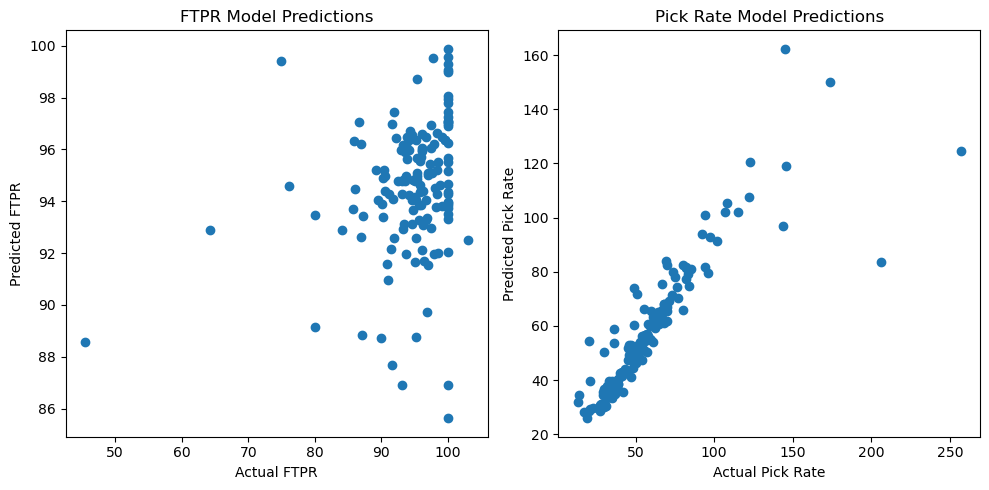

In [228]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Data Preprocessing
X = df[['Day of Pick Date', 'Qty Req to Pick', 'Pick Hours']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Convert date column to datetime format and extract day, month, year features
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
df['day_of_month'] = df['Day of Pick Date'].dt.day
df['month'] = df['Day of Pick Date'].dt.month

X = df[['Qty Req to Pick', 'Pick Hours', 'day_of_month', 'month']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Split data into training and testing sets
X_train, X_test, y_ftpr_train, y_ftpr_test = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_pick_rate_train, y_pick_rate_test = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
model_ftpr = RandomForestRegressor(n_estimators=100)
model_ftpr.fit(X_train_scaled, y_ftpr_train)

y_ftpr_pred = model_ftpr.predict(X_test_scaled)
print("FTPR Model Evaluation:")
print(f"MSE: {mean_squared_error(y_ftpr_test, y_ftpr_pred)}")
print(f"R2 Score: {r2_score(y_ftpr_test, y_ftpr_pred)}")

model_pick_rate = RandomForestRegressor(n_estimators=100)
model_pick_rate.fit(X_train_scaled, y_pick_rate_train)

y_pick_rate_pred = model_pick_rate.predict(X_test_scaled)
print("Pick Rate Model Evaluation:")
print(f"MSE: {mean_squared_error(y_pick_rate_test, y_pick_rate_pred)}")
print(f"R2 Score: {r2_score(y_pick_rate_test, y_pick_rate_pred)}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_ftpr_test, y_ftpr_pred)
plt.xlabel("Actual FTPR")
plt.ylabel("Predicted FTPR")
plt.title("FTPR Model Predictions")

plt.subplot(1, 2, 2)
plt.scatter(y_pick_rate_test, y_pick_rate_pred)
plt.xlabel("Actual Pick Rate")
plt.ylabel("Predicted Pick Rate")
plt.title("Pick Rate Model Predictions")

plt.tight_layout()
plt.show()


<h2>Attempt to try different models to improve accuracy</h2>

In [229]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for FTPR and Pick Rate models
ftpr_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20]
}

pick_rate_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20]
}

# Perform grid search for FTPR model
ftpr_gs = GridSearchCV(RandomForestRegressor(), ftpr_param_grid, cv=5)
ftpr_gs.fit(X_train_scaled, y_ftpr_train)

print("FTPR Model Best Parameters:", ftpr_gs.best_params_)
print("FTPR Model Best Score:", ftpr_gs.best_score_)

# Perform grid search for Pick Rate model
pick_rate_gs = GridSearchCV(RandomForestRegressor(), pick_rate_param_grid, cv=5)
pick_rate_gs.fit(X_train_scaled, y_pick_rate_train)

print("Pick Rate Model Best Parameters:", pick_rate_gs.best_params_)
print("Pick Rate Model Best Score:", pick_rate_gs.best_score_)

# Train models with best parameters and evaluate
ftpr_best_model = ftpr_gs.best_estimator_
pick_rate_best_model = pick_rate_gs.best_estimator_

y_ftpr_pred = ftpr_best_model.predict(X_test_scaled)
y_pick_rate_pred = pick_rate_best_model.predict(X_test_scaled)

print("FTPR Model Evaluation (Best Parameters):")
print("MSE:", mean_squared_error(y_ftpr_test, y_ftpr_pred))
print("R2 Score:", r2_score(y_ftpr_test, y_ftpr_pred))

print("Pick Rate Model Evaluation (Best Parameters):")
print("MSE:", mean_squared_error(y_pick_rate_test, y_pick_rate_pred))
print("R2 Score:", r2_score(y_pick_rate_test, y_pick_rate_pred))

FTPR Model Best Parameters: {'max_depth': 5, 'n_estimators': 100}
FTPR Model Best Score: -0.09527679123677942
Pick Rate Model Best Parameters: {'max_depth': 20, 'n_estimators': 50}
Pick Rate Model Best Score: 0.5630958702004064
FTPR Model Evaluation (Best Parameters):
MSE: 44.97404332351761
R2 Score: 0.02782749092825021
Pick Rate Model Evaluation (Best Parameters):
MSE: 356.4980273972603
R2 Score: 0.690396023568505


In [230]:
df.head()

Associate ID   Associate Name Day of Pick Date   FTPR  Pick Rate  Pick Hours  Qty Req to Pick  Picked As Req Qty  Substitution Qty  Nil Pick Qty  ...  Is Weekend  Year  Month  First Day of Month First Week of Month Week of Month Pick Hours per Qty Req  Total Exceptions  day_of_month  month
840       d0r0khi     Daniel Russo       2024-12-20  96.97       81.0        0.42             34.0                 32                 2             0  ...           0  2024     12          2024-12-01                  48             4               0.012353                 0            20     12
739       a0f0grp  Andrea Figueroa       2024-12-20  98.63       55.0        2.62            147.0                144                 1             2  ...           0  2024     12          2024-12-01                  48             4               0.017823                 2            20     12
896       e0s0frj      Ericka Suin       2024-12-20  90.91       45.0        1.11             55.0                 50                 0             5  ...           0  2024     12          2024-12-01                  48             4               0.020182                 0            20     12
1155      stufano    Sharon Tufano       2024-12-20  97.30       80.0        3.25            262.0                252                 8             1  ...           0  2024     12          2024-12-01                  48             4               0.012405                 0            20     12
752       a0p0fc6     Andrew Plaza       2024-12-20  94.00       36.0        1.34             50.0                 49                 0             0  ...           0  2024     12          2024-12-01                  48             4               0.026800                 0            20     12

[5 rows x 34 columns]

In [231]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Data Preparation
df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
df['Total Exceptions'] = (
    df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
    df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
)

X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
        'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
        'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Train-Test Split
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training for FTPR
ftpr_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
ftpr_model.fit(X_train_scaled, y_train_ftpr)

# Model Training for Pick Rate
pick_rate_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
pick_rate_model.fit(X_train_scaled, y_train_pick_rate)

# Model Training for Picked As Req Qty
picked_as_req_qty_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
picked_as_req_qty_model.fit(X_train_scaled, y_train_picked_as_req_qty)

# Predictions
ftpr_preds = ftpr_model.predict(X_test_scaled)
pick_rate_preds = pick_rate_model.predict(X_test_scaled)
picked_as_req_qty_preds = picked_as_req_qty_model.predict(X_test_scaled)

# Evaluation
print("FTPR Metrics")
print(f"MSE: {mean_squared_error(y_test_ftpr, ftpr_preds):.4f}")
print(f"R2: {r2_score(y_test_ftpr, ftpr_preds):.4f}")

print("\nPick Rate Metrics")
print(f"MSE: {mean_squared_error(y_test_pick_rate, pick_rate_preds):.4f}")
print(f"R2: {r2_score(y_test_pick_rate, pick_rate_preds):.4f}")

print("\nPicked As Req Qty Metrics")
print(f"MSE: {mean_squared_error(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")
print(f"R2: {r2_score(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")


FTPR Metrics
MSE: 23.7643
R2: 0.4863

Pick Rate Metrics
MSE: 101.4321
R2: 0.9119

Picked As Req Qty Metrics
MSE: 9.3637
R2: 0.9986


In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ===========================================
# Load and Preprocess Data
# ===========================================

# Example DataFrame (replace with actual data loading)
# df = pd.read_csv('your_dataset.csv')

# Convert 'Day of Pick Date' and other datetime columns to numeric features (e.g., day of the week)
if "Day of Pick Date" in df.columns:
    df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
    df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
    df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month

# Drop irrelevant columns
X = df.drop(columns=[
    "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
    "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
    "Composite_Score", "Associate ID"
])

# Target variables
y_ftpr = df["FTPR"]
y_pick_rate = df["Pick Rate"]

# Convert categorical features to numeric using one-hot encoding
X_numeric = pd.get_dummies(X, drop_first=True)

# Ensure all columns are numeric
X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X_numeric, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X_numeric, y_pick_rate, test_size=0.2, random_state=42)

# Scale numeric features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===========================================
# Train and Evaluate Models
# ===========================================

# Define a function to train and evaluate models
def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{label} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    return model

# Train Random Forest Regressor for FTPR
ftpr_model = RandomForestRegressor(n_estimators=500, random_state=42)
ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

# Train Random Forest Regressor for Pick Rate
pick_rate_model = RandomForestRegressor(n_estimators=500, random_state=42)
pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

# ===========================================
# Notes
# ===========================================
# - Handled datetime columns by extracting numeric features.
# - Dropped irrelevant columns to avoid data leakage.
# - Converted categorical features to numeric using `pd.get_dummies`.
# - Ensured all columns are numeric with `pd.to_numeric` and replaced NaN values with 0.
# - Scaled features using `StandardScaler` for improved model performance.


FTPR Metrics:
MSE: 34.0243
R2: 0.2645
Pick Rate Metrics:
MSE: 119.0509
R2: 0.8966


In [233]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define constants
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 500

def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("File not found.")
        return None

def preprocess_data(df):
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
    
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite_Score", "Associate ID"
    ])
    
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]
    
    X_numeric = pd.get_dummies(X, drop_first=True)
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
    
    return X_numeric, y_ftpr, y_pick_rate

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"{label} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return model

# Preprocess data
X, y_ftpr, y_pick_rate = preprocess_data(df)

# Split data
X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
_, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

FTPR Metrics:
MSE: 34.0243
R2: 0.2645
MAE: 2.8154
Pick Rate Metrics:
MSE: 119.0509
R2: 0.8966
MAE: 3.6322


In [234]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define constants
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 500

def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("File not found.")
        return None

def preprocess_data(df):
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
    
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite_Score", "Associate ID"
    ])
    
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]
    
    X_numeric = pd.get_dummies(X, drop_first=True)
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
    
    return X_numeric, y_ftpr, y_pick_rate

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"{label} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return model


# Preprocess data
X, y_ftpr, y_pick_rate = preprocess_data(df)

# Split data
X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
_, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

FTPR Metrics:
MSE: 34.0243
R2: 0.2645
MAE: 2.8154
Pick Rate Metrics:
MSE: 119.0509
R2: 0.8966
MAE: 3.6322


In [235]:
combine_data_to_csv()

Directory 'Data/Comnined/' already exists.
